In [1]:
!pip install --upgrade scikit-learn feature_engine shap catboost xgboost lightgbm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 75.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 18.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 24.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 75.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.0/199.0 MB 7.7 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.7
    Uninstalling slicer-0.0.7:
      Successfully uninstalled slicer-0.0.7
  Attempting uninstall: xgboost
    Found existing installation: xgboost 2.0.3
    Uninstalling xgboost-2.0.3:
      Successfully uninstalled xgboost-2.0.3
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Su

# Импорт библиотек

In [2]:
from feature_engine.imputation import MeanMedianImputer
from sklearn.impute import SimpleImputer
import pickle
import optuna
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import KFold
import re
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, f1_score, precision_score, recall_score, accuracy_score
from sklearn.preprocessing import label_binarize
from datetime import datetime, timedelta
import holidays
from tqdm import tqdm
import warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

warnings.simplefilter('ignore')
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=ConvergenceWarning)

seed = 42
np.random.seed(seed)

In [3]:
def plot_roc_curve(model, X, Y):
    """
    Функция для построения ROC кривой и вывода метрики AUC.

    Параметры:
    model: обученная модель, которая поддерживает метод predict_proba
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    """

    # Получение предсказанных вероятностей для положительного класса (1)
    y_proba = model.predict_proba(X)[:, 1]

    # Вычисляем ROC кривую и AUC
    fpr, tpr, thresholds = roc_curve(Y, y_proba)
    roc_auc = roc_auc_score(Y, y_proba)

    # Строим график
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Линия для случайного угадывания
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

In [4]:
# Импортируем библиотеку праздников для России
ru_holidays = holidays.Russia()

# Функция для определения сезона по месяцу даты
# Принимает на вход объект даты (date) и возвращает строку с названием сезона
def get_season(date) -> str:
    if date.month in [12, 1, 2]:
        return 'winter'  # Зима: декабрь, январь, февраль
    elif date.month in [3, 4, 5]:
        return 'spring'  # Весна: март, апрель, май
    elif date.month in [6, 7, 8]:
        return 'summer'  # Лето: июнь, июль, август
    else:
        return 'autumn'  # Осень: сентябрь, октябрь, ноябрь


# Основная функция для добавления временных признаков в DataFrame
# df - входной DataFrame, start_col - столбец с начальной датой, end_col - столбец с конечной датой
def create_time_features(df: pd.DataFrame, start_col: str, end_col: str) -> pd.DataFrame:
    # Преобразуем столбцы с датами в формат datetime для работы с ними как с датами
    df[start_col] = pd.to_datetime(df[start_col])
    df[end_col] = pd.to_datetime(df[end_col])  

    # Создаем новый столбец, который содержит диапазон всех дат от начальной до конечной
    df['date_range'] = df.apply(lambda row: pd.date_range(start=row[start_col], end=row[end_col]), axis=1)   

    # Создаем столбец с общим количеством дней в диапазоне
    df['total_days'] = df['date_range'].apply(len)   

    # Считаем долю зимних дней в диапазоне и нормализуем на общее количество дней
    df['winter'] = df['date_range'].apply(lambda dates: sum(get_season(date) == 'winter' for date in dates)) / df['total_days']   

    # Считаем долю весенних дней в диапазоне и нормализуем на общее количество дней
    df['spring'] = df['date_range'].apply(lambda dates: sum(get_season(date) == 'spring' for date in dates)) / df['total_days']    

    # Считаем долю летних дней в диапазоне и нормализуем на общее количество дней
    df['summer'] = df['date_range'].apply(lambda dates: sum(get_season(date) == 'summer' for date in dates)) / df['total_days']
    
    # Считаем долю осенних дней в диапазоне и нормализуем на общее количество дней
    df['autumn'] = df['date_range'].apply(lambda dates: sum(get_season(date) == 'autumn' for date in dates)) / df['total_days']   

    # Считаем долю праздничных дней в диапазоне на основе списка российских праздников
    df['holidays'] = df['date_range'].apply(lambda dates: sum(date in ru_holidays for date in dates)) / df['total_days']

    # Считаем долю выходных дней (суббота и воскресенье) и нормализуем на общее количество дней
    df['weekends'] = df['date_range'].apply(lambda dates: sum(date.weekday() >= 5 for date in dates)) / df['total_days']  

    # Считаем долю рабочих дней (понедельник-пятница) с учетом того, что праздники также считаются нерабочими
    df['workdays'] = df['date_range'].apply(lambda dates: sum(date.weekday() < 5 for date in dates) - sum(date in ru_holidays for date in dates)) / df['total_days']

    # Функция для подсчета количества "длинных" выходных
    # Длинные выходные определяются как выходные дни, соединенные с праздничными днями
    def count_long_weekends(dates):
        long_weekends = 0
        for i in range(1, len(dates)):  # Начинаем со второго дня диапазона
            # Если предыдущий день был выходным, а текущий — праздничным, увеличиваем счетчик длинных выходных
            if dates[i - 1].weekday() >= 5 and dates[i] in ru_holidays:
                long_weekends += 1
        return long_weekends

    
    # Добавляем столбец с долей длинных выходных дней в общем количестве дней
    df['long_weekends'] = df['date_range'].apply(lambda dates: count_long_weekends(dates)) / df['total_days']

    # Нормализуем общее количество дней на 366, чтобы учесть високосные годы
    df['total_days'] = df['total_days'] / 366

    return df  # Возвращаем DataFrame с новыми признаками

In [5]:
def reduce_mem_usage(df: pd.DataFrame) -> pd.DataFrame:
    """ Проходит по всем столбцам DataFrame и изменяет тип данных
        для уменьшения использования памяти.
    """

    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype.name

        if col_type not in ['object', 'category', 'datetime64[ns, UTC]']:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

In [6]:
def evaluate_models(models, model_names, X, Y) -> pd.DataFrame:
    """
    Функция для оценки списка моделей по метрикам точности, F1, полноты, точности, ROC AUC и Gini.

    Параметры:
    models (list): Список обученных моделей
    model_names (list): Список названий моделей
    X (numpy.ndarray): Набор данных для предсказания, shape (n_samples, n_features)
    Y (numpy.ndarray): Истинные ответы, shape (n_samples,)
    
    Возвращает:
    pandas.DataFrame: Таблица с метриками для каждой модели
    """

    if len(models) != len(model_names):
        raise ValueError("Списки моделей и названий моделей должны быть одинаковой длины")

    results = []
    for model, name in zip(models, model_names):
        y_pred = model.predict(X)
        accuracy = accuracy_score(Y, y_pred)
        f1 = f1_score(Y, y_pred)
        recall = recall_score(Y, y_pred)
        precision = precision_score(Y, y_pred)

        # Вычисление предсказания вероятностей для метрик ROC AUC и Gini
        if hasattr(model, "predict_proba"):
            y_proba = model.predict_proba(X)[:, 1]
            roc_auc = roc_auc_score(Y, y_proba)
            gini = 2 * roc_auc - 1
        else:
            roc_auc = None
            gini = None

        results.append({
            'Model': name,
            'Accuracy': accuracy,
            'F1 Score': f1,
            'Recall': recall,
            'Precision': precision,
            'ROC AUC': roc_auc,
            'Gini': gini

        })
    results_df = pd.DataFrame(results)
    return results_df

In [7]:
# Функция для создания дополнительных признаков на основе финансовых и других данных
def create_advanced_features(df: pd.DataFrame) -> pd.DataFrame:
    # Финансовые коэффициенты
    # Текущая ликвидность (Current Ratio)
    # Показывает отношение текущих активов компании к её краткосрочным обязательствам.
    # Формула: Текущие активы / Краткосрочные обязательства
    df['current_ratio'] = df['agg_Finance__g_contractor__Value__CurrentAssets__last__ALL_TIME'] / df['agg_Finance__g_contractor__Value__ShortLiabilities__last__ALL_TIME']

    # Соотношение долга к капиталу (Debt to Equity Ratio)
    # Показывает соотношение долгов компании (краткосрочные и долгосрочные обязательства) к её собственному капиталу.
    # Формула: (Краткосрочные обязательства + Долгосрочные обязательства) / Собственный капитал
    df['debt_to_equity'] = (df['agg_Finance__g_contractor__Value__ShortLiabilities__last__ALL_TIME'] + df['agg_Finance__g_contractor__Value__LongLiabilities__last__ALL_TIME']) / df['agg_Finance__g_contractor__Value__Capital__last__ALL_TIME']

    # Рентабельность активов (Return on Assets, ROA)
    # Показывает, насколько эффективно компания использует свои активы для получения прибыли.
    # Формула: Чистая прибыль / Общие активы
    df['return_on_assets'] = df['agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME'] / df['agg_Finance__g_contractor__Value__Balance__last__ALL_TIME']

    # Динамика изменения финансовых и судебных показателей
    # Изменение сумм исков против компании за последние 12 месяцев по сравнению с предыдущими 12-24 месяцами
    df['claims_change_12_24'] = df['agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M'] - df['agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M']

    # Изменение сумм исков против компании за предыдущие 12-24 месяца по сравнению с 24-36 месяцами
    df['claims_change_24_36'] = df['agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M'] - df['agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_36M']
    
    # Изменение прибыли компании относительно её выручки
    # Показывает, насколько прибыльной была компания относительно общего дохода (выручки).
    # Формула: Чистая прибыль / Выручка
    df['profit_change'] = df['agg_Finance__g_contractor__Value__NetProfit_y__last__ALL_TIME'] / df['agg_Finance__g_contractor__Value__Revenue_y__last__ALL_TIME']
    
    # Суммарные показатели и рейтинги
    # Индекс надежности компании
    # Рассчитывается как среднее значение нескольких индексов, которые отражают общее состояние компании,
    # её риск несостоятельности, платежеспособность и уровень добросовестности.
    df['reliability_index'] = (
        df['agg_ConsolidatedIndicator__g_contractor__Index__Overall__mean__ALL_TIME'] +  # Общий индекс компании
        df['agg_ConsolidatedIndicator__g_contractor__Index__FailureScore__mean__ALL_TIME'] +  # Индекс вероятности банкротства
        df['agg_ConsolidatedIndicator__g_contractor__Index__PaymentIndex__mean__ALL_TIME'] +  # Платежный индекс
        df['agg_ConsolidatedIndicator__g_contractor__Index__IndexOfDueDiligence__mean__ALL_TIME']  # Индекс добросовестности
    ) / 4  # Среднее значение этих индексов

    # Активность по залогам
    # Активность по залогам — разница между количеством активных залогов и прекращённых залогов.
    df['pledger_activity'] = df['agg_spark_extended_report__g_contractor__PledgerActiveCount__last__ALL_TIME'] - df['agg_spark_extended_report__g_contractor__PledgerCeasedCount__last__ALL_TIME']

    # Исторические данные по искам
    # Общая сумма исков за последние 12 месяцев (ответчик и истец)
    df['total_claims_last_12_months'] = df['agg_ArbitrationCases__g_contractor__DefendantSum__sum__12M'] + df['agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12M']

    # Общая сумма исков за последние 24 месяца (ответчик и истец)
    df['total_claims_last_24_months'] = df['agg_ArbitrationCases__g_contractor__DefendantSum__sum__12_24M'] + df['agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_24M']

    # Логарифмическое преобразование
    # Логарифм от оценочной суммы обязательств компании
    df['agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME'] = np.log1p(df['agg_spark_extended_report__g_contractor__EstimatedLiabilitiesSum__last__ALL_TIME'])
    # Логарифм от выручки компании за последний год
    df['agg_Finance__g_contractor__Value__Revenue_y__last__ALL_TIME'] = np.log1p(df['agg_Finance__g_contractor__Value__Revenue_y__last__ALL_TIME'])
    
    # Новые финансовые признаки
    # Абсолютное изменение суммы контракта (текущая сумма минус начальная сумма)
    df['contract_sum_change'] = df['contract_current_sum'] - df['contract_init_sum']

    # Процентное изменение суммы контракта (относительное изменение текущей суммы к начальной)
    # Если значение бесконечно (например, начальная сумма контракта была 0), заменяем его на NaN
    df['contract_sum_change_percentage'] = (df['contract_sum_change'] / df['contract_init_sum']).replace([np.inf, -np.inf], np.nan)

    # Логарифм от текущей суммы контракта (логарифмическое преобразование для нормализации данных)
    df['contract_current_sum'] = np.log1p(df['contract_current_sum'])
    
    # Нормализуем изменение суммы контракта по общему количеству контрактов
    # Делим изменение суммы контракта на количество контрактов, чтобы получить среднее изменение на контракт
    df['contract_change_per_contract'] = df['contract_sum_change'] / df['agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME']
    return df  # Возвращаем DataFrame с новыми признаками

# Анализ данных и очистка

In [ ]:
data = pd.read_csv('data/train_X.csv')
Y = pd.read_csv('data/train_y.csv')

In [9]:
data = pd.merge(data, Y, how='left', on=['contract_id', 'report_date'])
data

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,default6
0,5433,2023-01-01,18,1.115267,2022-05-10 21:00:00,43,701,438,0.793952,-0.539030,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
1,6875,2023-01-01,18,1.608002,2022-08-21 21:00:00,31,268,438,2.681675,0.743673,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
2,1476,2023-01-01,18,-0.360764,2022-10-17 21:00:00,31,268,438,-0.416432,-0.539030,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
3,4469,2023-01-01,12,-0.089303,2022-04-20 21:00:00,43,697,484,-0.193827,-0.539030,...,-0.158471,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
4,1330,2023-01-01,12,-0.515778,2022-03-02 21:00:00,49,224,484,0.133446,0.743673,...,-0.158471,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,5078,2023-07-23,21,-0.484227,2023-04-13 21:00:00,18,915,683,-0.504509,0.743673,...,NaN,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0
28827,3854,2023-07-23,21,-0.500003,2023-04-13 21:00:00,18,915,683,-0.524174,0.743673,...,NaN,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0
28828,5351,2023-07-23,21,-0.481102,2023-07-16 21:00:00,50,298,683,-0.515112,-0.539030,...,NaN,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0
28829,57,2023-07-23,21,-0.468450,2023-03-16 21:00:00,45,915,683,-0.504737,-0.539030,...,NaN,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0


## Проверка на пустые значения и заполнение их

#### Отбираем фичи в которых слишком много пустых значений(больше 70% это NaN), а так же отбирем фичи для imputer-а, которые можно заполнить

In [10]:
data_del_par, nan_par = [], []


for i in data.isnull().sum().items():
    if i[-1] > len(data) * 0.7:
        data_del_par.append(i[0])
        print(i)

    if 0 < i[-1] <= len(data) * 0.7:
        nan_par.append(i[0])

('agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME', 21507)
('agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME', 21507)
('agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME', 23736)
('agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME', 23736)
('agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME', 25425)


#### Удалим фичи где слишком много пустых значений(больше 70% это NaN)

In [11]:
data = data.drop(columns=data_del_par)
data_del_par

['agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME',
 'agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__mean__ALL_TIME',
 'agg_FinanceAndTaxesFTS__g_contractor__TaxPenaltiesSum__last__ALL_TIME']

In [12]:
nan_par

['agg_scontrol__g_contractor__close_delay__defect_type_repair__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_author_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_GR__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_general_contractor__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_arch_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'agg_scontrol__g_contractor__close_delay__defect_type_app__mean__ALL_TIME',
 'agg_sroomer__g_contractor__sroomer_id__count__3M',
 'agg_sroomer__g_contractor__sroomer_id__count__6M',
 'agg_sroomer__g_contractor__sroomer_id__count__12M',
 'agg_sroomer__g_contractor__sroomer_id__count__ALL_TIME',
 'agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME',
 'agg_ConsolidatedIndicator__g_

#### Заполним пропуски средним, т.к. оно больше подходит для этого чем медиана, так как данные стандартизированы

In [13]:
imputer = MeanMedianImputer(imputation_method='mean', variables=nan_par)
imputer.fit(data[nan_par])
data[nan_par] = imputer.transform(data[nan_par])

In [14]:
pickle.dump(imputer, open("MeanMedianImputer.pickle", "wb"))

## Получившийся датасет

In [15]:
data

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,default6
0,5433,2023-01-01,18,1.115267,2022-05-10 21:00:00,43,701,438,0.793952,-0.539030,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
1,6875,2023-01-01,18,1.608002,2022-08-21 21:00:00,31,268,438,2.681675,0.743673,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
2,1476,2023-01-01,18,-0.360764,2022-10-17 21:00:00,31,268,438,-0.416432,-0.539030,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
3,4469,2023-01-01,12,-0.089303,2022-04-20 21:00:00,43,697,484,-0.193827,-0.539030,...,-0.158471,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
4,1330,2023-01-01,12,-0.515778,2022-03-02 21:00:00,49,224,484,0.133446,0.743673,...,-0.158471,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,5078,2023-07-23,21,-0.484227,2023-04-13 21:00:00,18,915,683,-0.504509,0.743673,...,-0.019311,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0
28827,3854,2023-07-23,21,-0.500003,2023-04-13 21:00:00,18,915,683,-0.524174,0.743673,...,-0.019311,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0
28828,5351,2023-07-23,21,-0.481102,2023-07-16 21:00:00,50,298,683,-0.515112,-0.539030,...,-0.019311,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0
28829,57,2023-07-23,21,-0.468450,2023-03-16 21:00:00,45,915,683,-0.504737,-0.539030,...,-0.019311,-0.136894,-0.009243,-0.093062,-0.095692,-0.132309,0.179293,0.150820,0.148360,0


#### Также заметим, что соотношение 0 и 1 - 84% и 16%

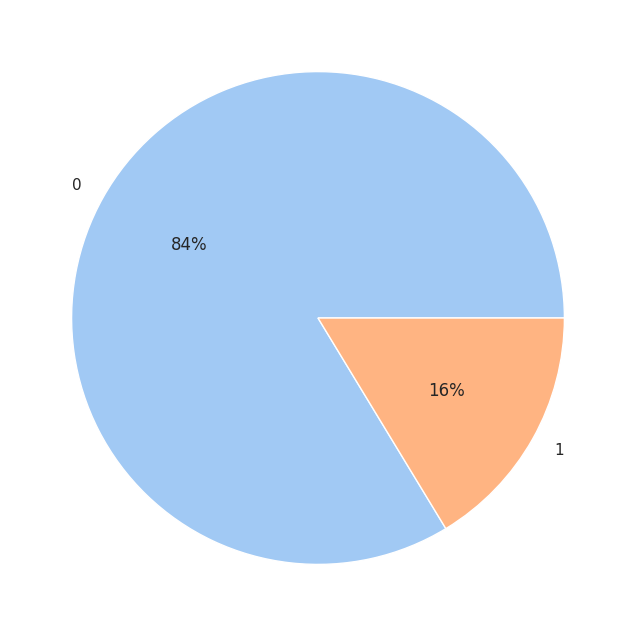

In [16]:
sns.set(rc={'figure.figsize': (15, 8)})
colors = sns.color_palette('pastel')[0:5]
labels = sorted(data['default6'].unique())
dt = np.array([len(data[data['default6'] == i])for i in labels])
plt.pie(dt, labels=labels, colors = colors, autopct='%.0f%%')
plt.show()

## Предобработаем тестовую выборку(заполним пропуски, остальное сделаем после проверок гипотез)

In [ ]:
test = pd.read_csv('data/test2_X.csv')

In [18]:
test = test.drop(columns=data_del_par)
test[nan_par] = imputer.transform(test[nan_par])
test

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME
0,3029,2023-07-30,15,-0.347029,2023-07-24 21:00:00,42,84,637,-0.405169,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
1,4350,2023-07-30,11,-0.092977,2023-07-11 21:00:00,44,727,637,-0.196840,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
2,1095,2023-07-30,15,-0.467957,2023-07-24 21:00:00,44,728,637,-0.504333,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
3,2634,2023-07-30,15,-0.486723,2023-07-24 21:00:00,44,727,637,-0.519721,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
4,6535,2023-07-30,11,-0.452585,2023-07-27 21:00:00,42,85,637,-0.491727,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,650,2023-10-29,6,9.432208,2023-10-14 21:00:00,5,401,327,7.614058,-0.539030,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13212,4277,2023-10-29,9,0.470615,2023-03-06 21:00:00,28,204,327,0.350311,0.743673,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13213,7316,2023-10-29,14,2.669630,2023-08-15 21:00:00,16,915,52,2.051660,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767
13214,7113,2023-10-29,14,-0.420756,2023-08-15 21:00:00,16,915,52,-0.465753,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767


## Сделаем гипотезы

- проверка id, какие из индификаторов следует оставить

- составим идеи работы с графом

- сформируем фичи сезоности, т.к. они могут влиять на объем работ при строительстве/обслуживании

- дополним финансовые фичи

## Начнём с гипотезы №1: ID

In [19]:
test[test['contractor_id'].isin(data['contractor_id'])]

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME
0,3029,2023-07-30,15,-0.347029,2023-07-24 21:00:00,42,84,637,-0.405169,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
1,4350,2023-07-30,11,-0.092977,2023-07-11 21:00:00,44,727,637,-0.196840,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
2,1095,2023-07-30,15,-0.467957,2023-07-24 21:00:00,44,728,637,-0.504333,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
3,2634,2023-07-30,15,-0.486723,2023-07-24 21:00:00,44,727,637,-0.519721,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
4,6535,2023-07-30,11,-0.452585,2023-07-27 21:00:00,42,85,637,-0.491727,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13207,6617,2023-10-29,14,-0.515778,2023-04-09 21:00:00,47,618,137,0.845283,3.309079,...,-0.158471,-0.158470,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13208,5948,2023-10-29,12,-0.313821,2023-07-25 21:00:00,0,804,137,-0.377937,-0.539030,...,-0.158471,-0.158470,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13210,746,2023-10-29,12,0.095455,2023-07-10 21:00:00,26,169,137,-0.042321,-0.539030,...,-0.158471,-0.158470,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13211,650,2023-10-29,6,9.432208,2023-10-14 21:00:00,5,401,327,7.614058,-0.539030,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454


#### Заметим, что подрядчики из train есть и в test

In [20]:
test[test['contract_id'].isin(data['contract_id'])]

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME


#### Довольно логично, что контракты не пересекаются -> contract_id - удаляем

In [21]:
test[test['building_id'].isin(data['building_id'])]

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME
0,3029,2023-07-30,15,-0.347029,2023-07-24 21:00:00,42,84,637,-0.405169,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
1,4350,2023-07-30,11,-0.092977,2023-07-11 21:00:00,44,727,637,-0.196840,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
2,1095,2023-07-30,15,-0.467957,2023-07-24 21:00:00,44,728,637,-0.504333,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
3,2634,2023-07-30,15,-0.486723,2023-07-24 21:00:00,44,727,637,-0.519721,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
4,6535,2023-07-30,11,-0.452585,2023-07-27 21:00:00,42,85,637,-0.491727,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,650,2023-10-29,6,9.432208,2023-10-14 21:00:00,5,401,327,7.614058,-0.539030,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13212,4277,2023-10-29,9,0.470615,2023-03-06 21:00:00,28,204,327,0.350311,0.743673,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13213,7316,2023-10-29,14,2.669630,2023-08-15 21:00:00,16,915,52,2.051660,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767
13214,7113,2023-10-29,14,-0.420756,2023-08-15 21:00:00,16,915,52,-0.465753,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767


#### Ещё в train и test есть одни и те же здания

In [22]:
test[test['project_id'].isin(data['project_id'])]

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME
0,3029,2023-07-30,15,-0.347029,2023-07-24 21:00:00,42,84,637,-0.405169,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
1,4350,2023-07-30,11,-0.092977,2023-07-11 21:00:00,44,727,637,-0.196840,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
2,1095,2023-07-30,15,-0.467957,2023-07-24 21:00:00,44,728,637,-0.504333,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
3,2634,2023-07-30,15,-0.486723,2023-07-24 21:00:00,44,727,637,-0.519721,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
4,6535,2023-07-30,11,-0.452585,2023-07-27 21:00:00,42,85,637,-0.491727,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,650,2023-10-29,6,9.432208,2023-10-14 21:00:00,5,401,327,7.614058,-0.539030,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13212,4277,2023-10-29,9,0.470615,2023-03-06 21:00:00,28,204,327,0.350311,0.743673,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13213,7316,2023-10-29,14,2.669630,2023-08-15 21:00:00,16,915,52,2.051660,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767
13214,7113,2023-10-29,14,-0.420756,2023-08-15 21:00:00,16,915,52,-0.465753,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767


#### Id почти всех проектов есть и в train и в test

In [23]:
test[test['specialization_id'].isin(data['specialization_id'])]

,contract_id,report_date,specialization_id,contract_init_sum,contract_date,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME
0,3029,2023-07-30,15,-0.347029,2023-07-24 21:00:00,42,84,637,-0.405169,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
1,4350,2023-07-30,11,-0.092977,2023-07-11 21:00:00,44,727,637,-0.196840,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
2,1095,2023-07-30,15,-0.467957,2023-07-24 21:00:00,44,728,637,-0.504333,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
3,2634,2023-07-30,15,-0.486723,2023-07-24 21:00:00,44,727,637,-0.519721,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
4,6535,2023-07-30,11,-0.452585,2023-07-27 21:00:00,42,85,637,-0.491727,-0.539030,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,650,2023-10-29,6,9.432208,2023-10-14 21:00:00,5,401,327,7.614058,-0.539030,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13212,4277,2023-10-29,9,0.470615,2023-03-06 21:00:00,28,204,327,0.350311,0.743673,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13213,7316,2023-10-29,14,2.669630,2023-08-15 21:00:00,16,915,52,2.051660,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767
13214,7113,2023-10-29,14,-0.420756,2023-08-15 21:00:00,16,915,52,-0.465753,0.743673,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767


#### ID специализации - id, которое имеет самое большое пересечение train и test, поэтому его мы точно оставляем

### Итог:



#### Мы решили оставить все id колонки, так как они помогут модели "запомнить" каждое здание или подрядчика, например если 1 подрядчик постоянно плохо работает или какой-то проект всегда успешен

## Гипотеза №2: Использование графа и анализ его данных

In [ ]:
graph = pd.read_csv('data/graph.csv').drop(columns=['Unnamed: 0'])
graph

,contractor_id1,contractor_id2,Distance
0,599,215,26
1,884,653,18
2,731,391,27
3,136,113,28
4,231,266,20
...,...,...,...
327181,106,441,14
327182,21,48,30
327183,504,480,20
327184,649,853,31


In [25]:
graph.describe()

,contractor_id1,contractor_id2,Distance
count,327186.000000,327186.000000,327186.000000
mean,462.618581,440.901961,653.996329
std,263.216242,258.214003,4493.804513
min,0.000000,0.000000,2.000000
25%,227.000000,223.000000,18.000000
50%,480.000000,433.000000,25.000000
75%,691.000000,668.000000,31.000000
max,898.000000,898.000000,32767.000000


### На основе этого графа можно рассмотреть, как вообще компании (contractor_id) относятся друг к другу и насколько между собой связаны

### Функция для создания колонок на основе графов

In [26]:
def work_graph(df: pd.DataFrame, graph: pd.DataFrame) -> pd.DataFrame:
    # Группируем данные по столбцу 'contractor_id1' и считаем различные статистики для столбца 'Distance'.
    # Эти словари будут содержать минимальные, максимальные, средние, медианные, суммарные значения,
    # а также количество записей для каждой уникальной contractor_id1.
    contractor1_group = graph.groupby('contractor_id1')['Distance']
    
    contractor1_min = contractor1_group.min().to_dict()       # Минимальные расстояния по contractor_id1
    contractor1_max = contractor1_group.max().to_dict()       # Максимальные расстояния по contractor_id1
    contractor1_mean = contractor1_group.mean().to_dict()     # Средние расстояния по contractor_id1
    contractor1_median = contractor1_group.median().to_dict() # Медианные расстояния по contractor_id1
    contractor1_sum = contractor1_group.sum().to_dict()       # Сумма расстояний по contractor_id1
    contractor1_count = contractor1_group.count().to_dict()   # Количество записей по contractor_id1

    # Группируем данные по столбцу 'contractor_id2' и считаем аналогичные статистики для 'Distance'.
    # Эти словари содержат значения для contractor_id2, как и выше для contractor_id1.
    contractor2_group = graph.groupby('contractor_id2')['Distance']
    
    contractor2_min = contractor2_group.min().to_dict()       # Минимальные расстояния по contractor_id2
    contractor2_max = contractor2_group.max().to_dict()       # Максимальные расстояния по contractor_id2
    contractor2_mean = contractor2_group.mean().to_dict()     # Средние расстояния по contractor_id2
    contractor2_median = contractor2_group.median().to_dict() # Медианные расстояния по contractor_id2
    contractor2_sum = contractor2_group.sum().to_dict()       # Сумма расстояний по contractor_id2
    contractor2_count = contractor2_group.count().to_dict()   # Количество записей по contractor_id2

    # Добавляем новые столбцы в DataFrame `df`, используя рассчитанные словари.
    # map() связывает значения `contractor_id` в `df` с соответствующими значениями из словарей.
    # Значения, для которых не нашлось совпадения, заполняются -1 (для чисел) и 0 (для количества записей).
    df['Distance_to_contractor_min'] = df['contractor_id'].map(contractor1_min).fillna(-1)
    df['Distance_to_contractor_max'] = df['contractor_id'].map(contractor1_max).fillna(-1)
    df['Distance_to_contractor_mean'] = df['contractor_id'].map(contractor1_mean).fillna(-1)
    df['Distance_to_contractor_median'] = df['contractor_id'].map(contractor1_median).fillna(-1)
    df['Distance_to_contractor_sum'] = df['contractor_id'].map(contractor1_sum).fillna(-1)
    df['Distance_to_contractor_count'] = df['contractor_id'].map(contractor1_count).fillna(0)
    
    # Повторяем тот же процесс для contractor_id2, заполняя соответствующие столбцы в DataFrame `df`.
    df['Distance_from_contractor_min'] = df['contractor_id'].map(contractor2_min).fillna(-1)
    df['Distance_from_contractor_max'] = df['contractor_id'].map(contractor2_max).fillna(-1)
    df['Distance_from_contractor_mean'] = df['contractor_id'].map(contractor2_mean).fillna(-1)
    df['Distance_from_contractor_median'] = df['contractor_id'].map(contractor2_median).fillna(-1)
    df['Distance_from_contractor_sum'] = df['contractor_id'].map(contractor2_sum).fillna(-1)
    df['Distance_from_contractor_count'] = df['contractor_id'].map(contractor2_count).fillna(0)

    # Возвращаем измененный DataFrame с добавленными столбцами.
    return df

In [27]:
data = work_graph(data, graph)
data[['contractor_id', 'Distance_to_contractor_mean', 'Distance_to_contractor_median', 'Distance_to_contractor_sum', 'Distance_to_contractor_count',
     'Distance_from_contractor_mean', 'Distance_from_contractor_median', 'Distance_from_contractor_sum', 'Distance_from_contractor_count',
    'Distance_to_contractor_min', 'Distance_to_contractor_max', 'Distance_from_contractor_min', 'Distance_from_contractor_max']]

,contractor_id,Distance_to_contractor_mean,Distance_to_contractor_median,Distance_to_contractor_sum,Distance_to_contractor_count,Distance_from_contractor_mean,Distance_from_contractor_median,Distance_from_contractor_sum,Distance_from_contractor_count,Distance_to_contractor_min,Distance_to_contractor_max,Distance_from_contractor_min,Distance_from_contractor_max
0,438,20.984615,20.0,1364.0,65.0,367.911023,17.0,277037.0,753.0,12.0,35.0,6.0,32767.0
1,438,20.984615,20.0,1364.0,65.0,367.911023,17.0,277037.0,753.0,12.0,35.0,6.0,32767.0
2,438,20.984615,20.0,1364.0,65.0,367.911023,17.0,277037.0,753.0,12.0,35.0,6.0,32767.0
3,484,547.792553,24.0,102985.0,188.0,236.892456,26.0,147584.0,623.0,12.0,32767.0,6.0,32767.0
4,484,547.792553,24.0,102985.0,188.0,236.892456,26.0,147584.0,623.0,12.0,32767.0,6.0,32767.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
28826,683,483.514085,23.0,274636.0,568.0,24.483871,25.0,6072.0,248.0,10.0,32767.0,7.0,43.0
28827,683,483.514085,23.0,274636.0,568.0,24.483871,25.0,6072.0,248.0,10.0,32767.0,7.0,43.0
28828,683,483.514085,23.0,274636.0,568.0,24.483871,25.0,6072.0,248.0,10.0,32767.0,7.0,43.0
28829,683,483.514085,23.0,274636.0,568.0,24.483871,25.0,6072.0,248.0,10.0,32767.0,7.0,43.0


### Получившиеся колонки

<Axes: >

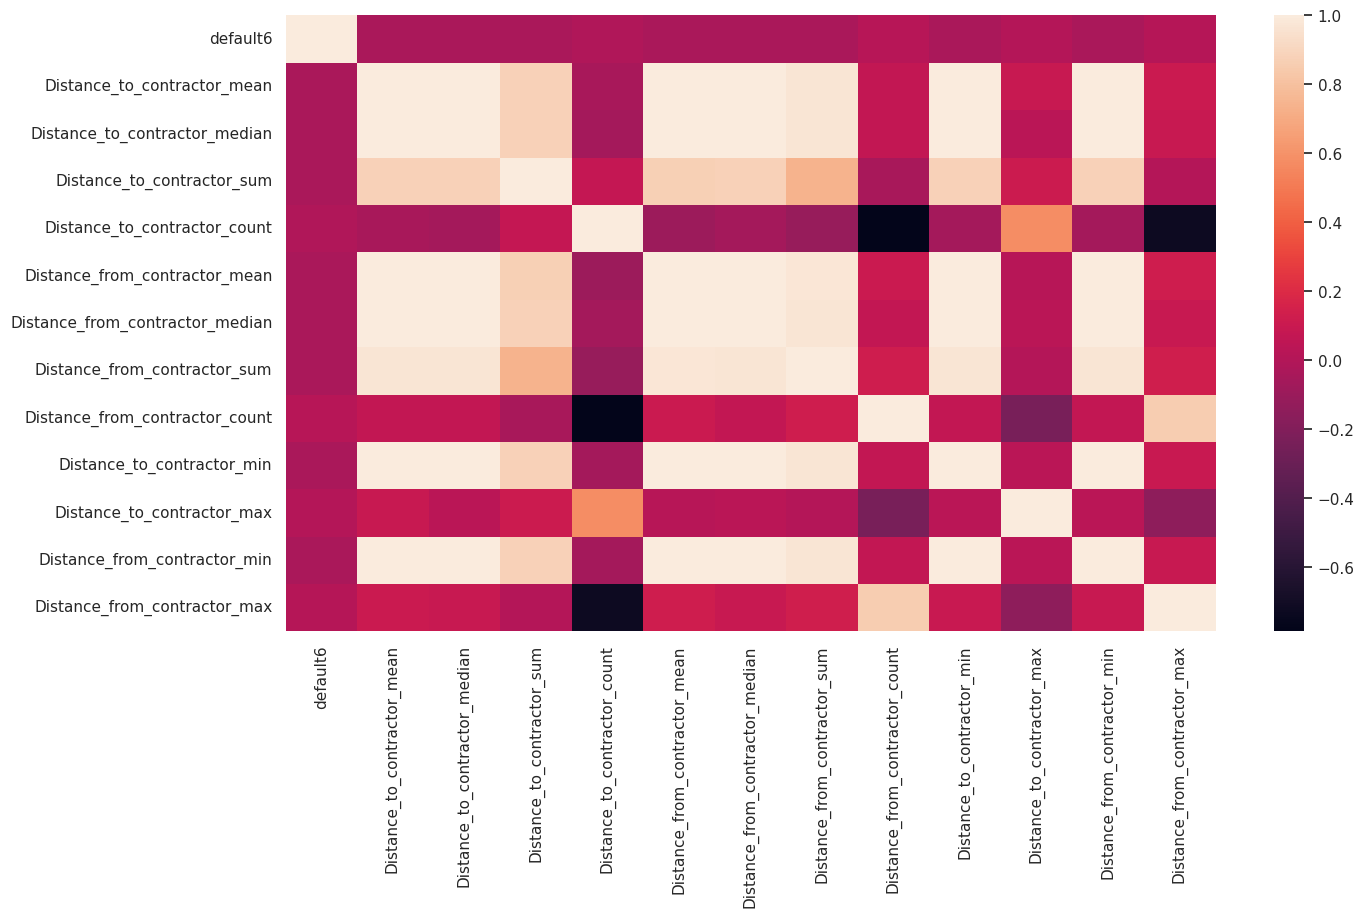

In [28]:
dt = work_graph(data, graph)[
    ['default6', 'Distance_to_contractor_mean', 'Distance_to_contractor_median', 'Distance_to_contractor_sum', 'Distance_to_contractor_count',
     'Distance_from_contractor_mean', 'Distance_from_contractor_median', 'Distance_from_contractor_sum', 'Distance_from_contractor_count',
    'Distance_to_contractor_min', 'Distance_to_contractor_max', 'Distance_from_contractor_min', 'Distance_from_contractor_max']]


correlation_matrix = dt.corr()
sns.heatmap(correlation_matrix)

### Тепловая карта корреляций

In [29]:
dt.corr()['default6']

default6                           1.000000
Distance_to_contractor_mean       -0.034927
Distance_to_contractor_median     -0.036023
Distance_to_contractor_sum        -0.032647
Distance_to_contractor_count      -0.006025
Distance_from_contractor_mean     -0.035143
Distance_from_contractor_median   -0.036005
Distance_from_contractor_sum      -0.033584
Distance_from_contractor_count     0.017615
Distance_to_contractor_min        -0.036020
Distance_to_contractor_max         0.007590
Distance_from_contractor_min      -0.036028
Distance_from_contractor_max       0.015235
Name: default6, dtype: float64

### Заметим из тепловой карты корреляции и самой таблицы корреляций, что зависимость между нашими переменными и дефолтом существуют, теперь рассмотрим распределения:

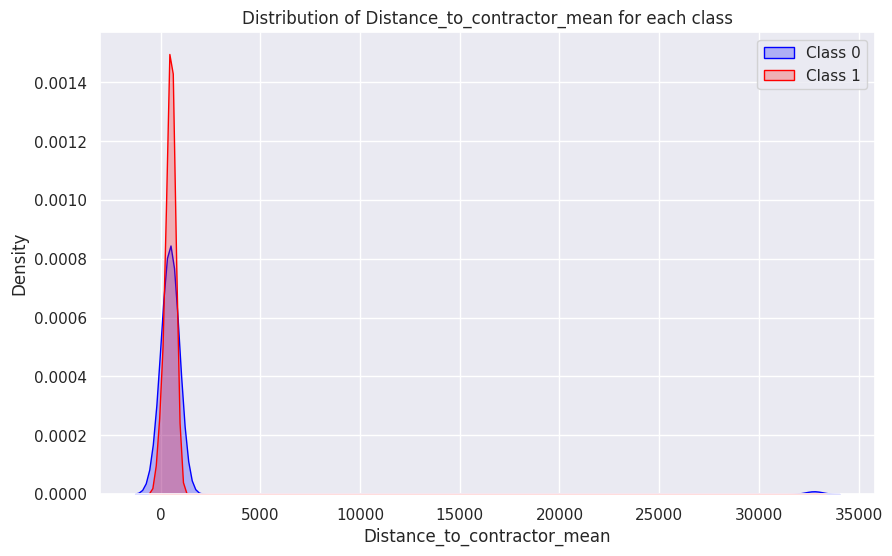

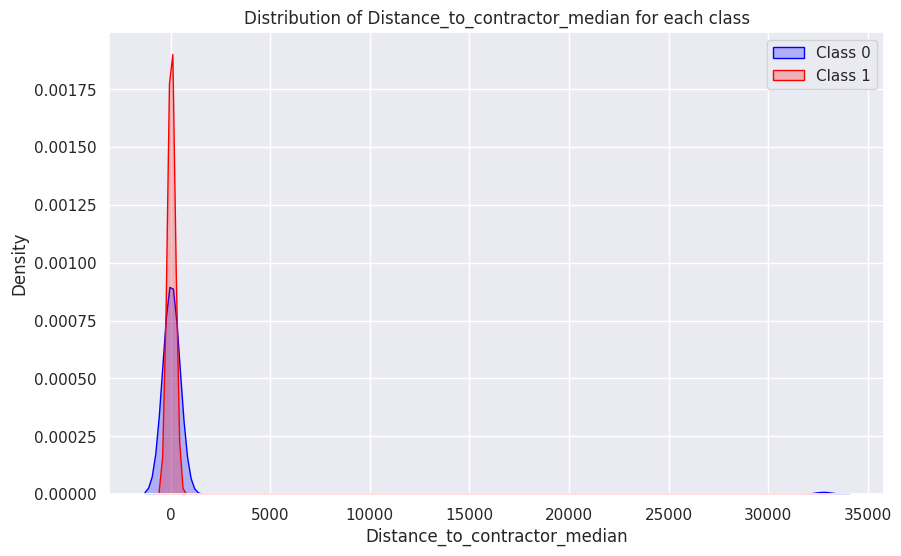

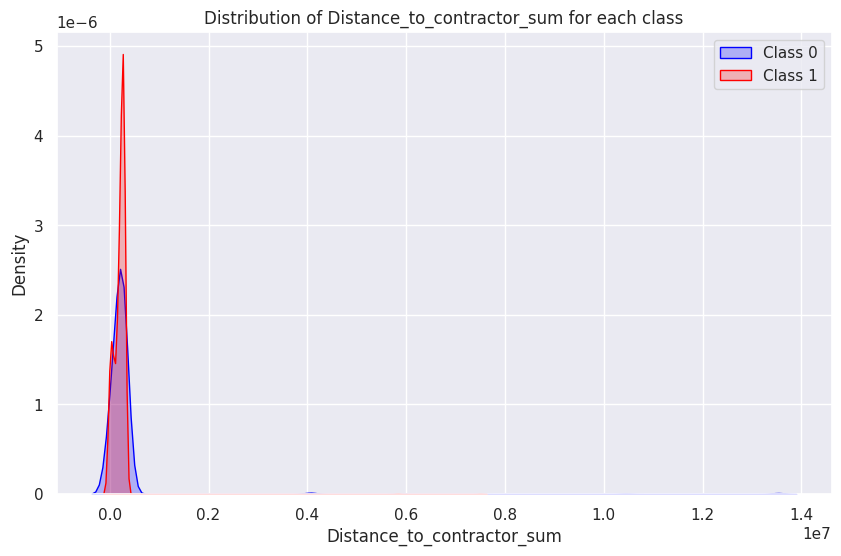

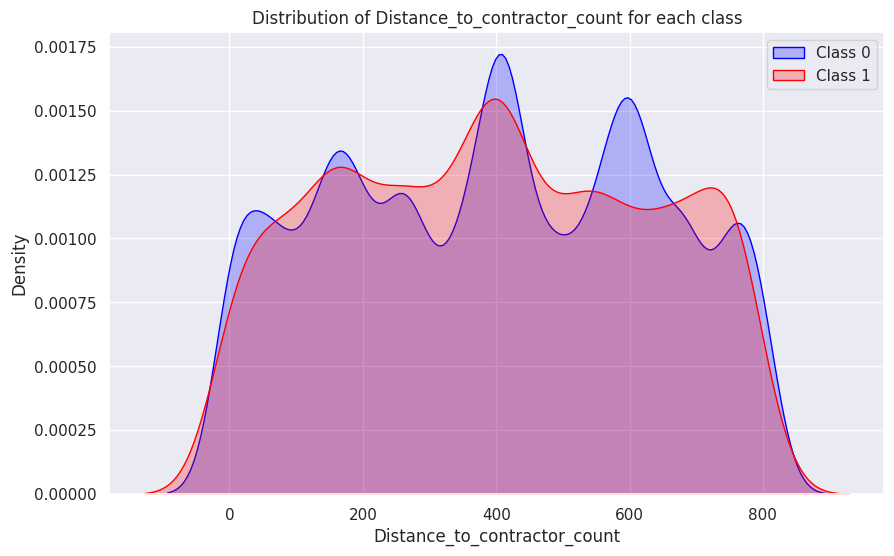

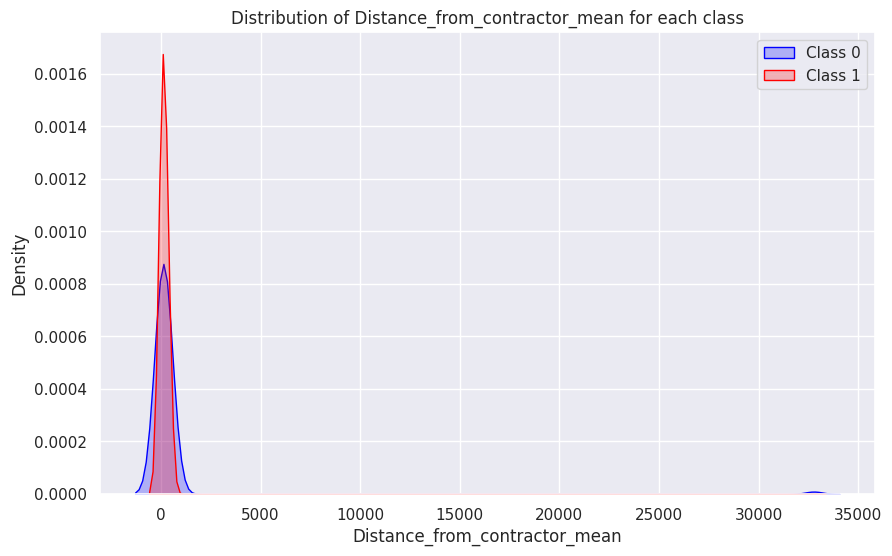

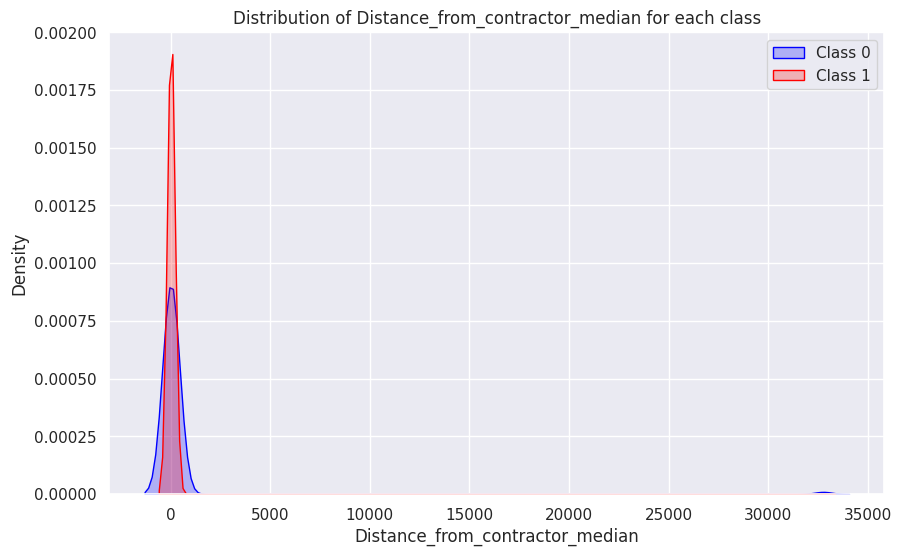

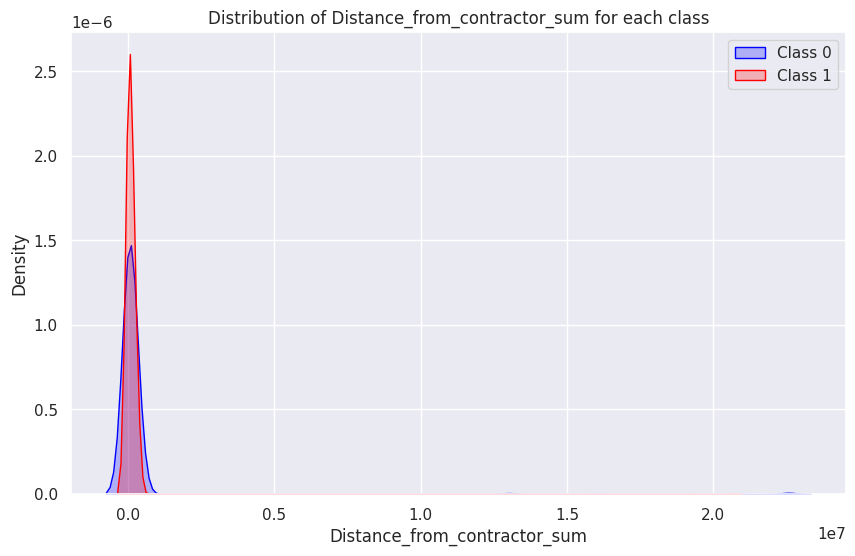

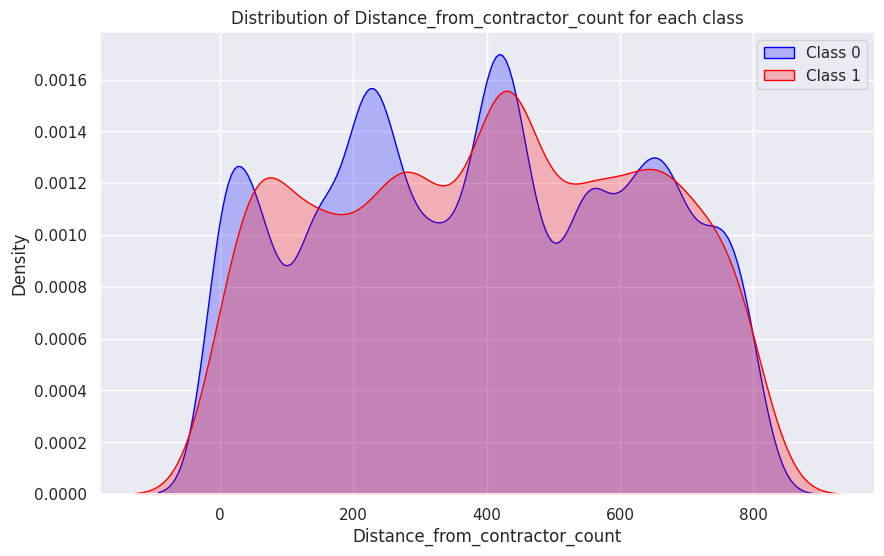

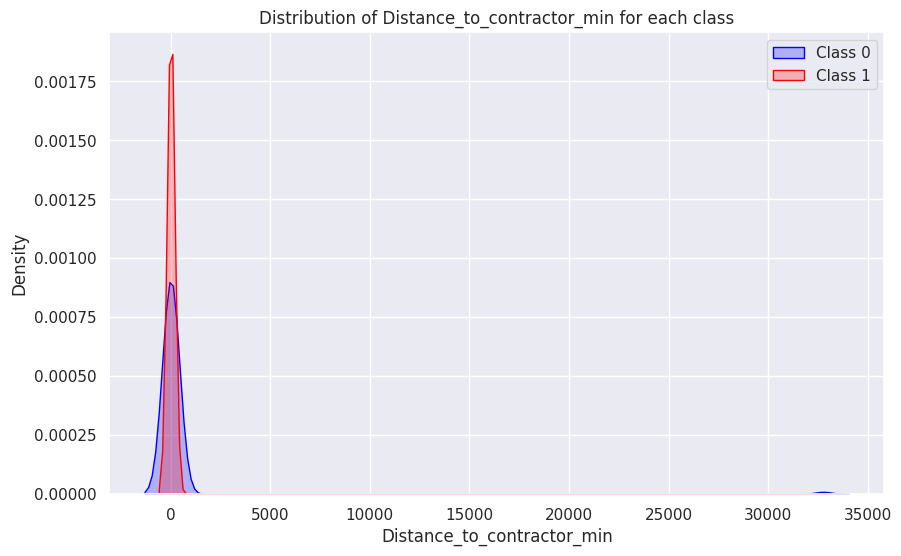

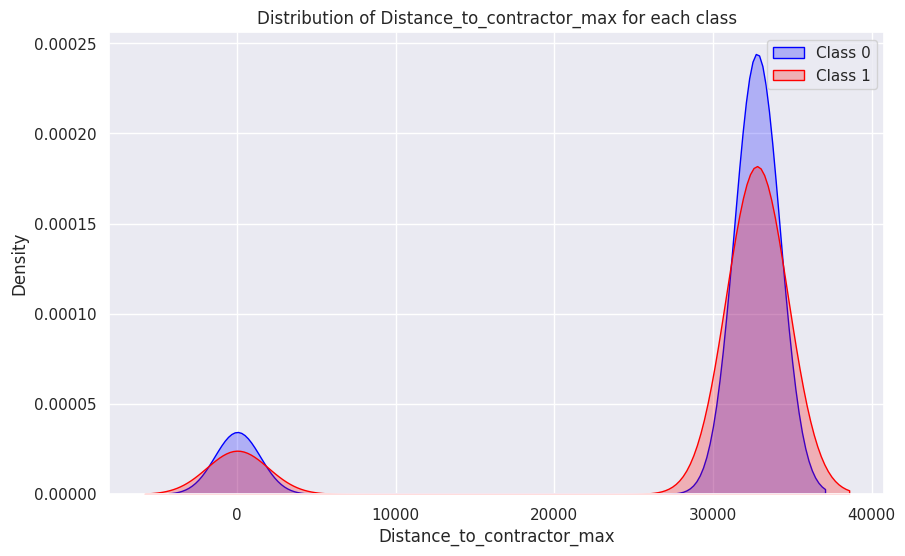

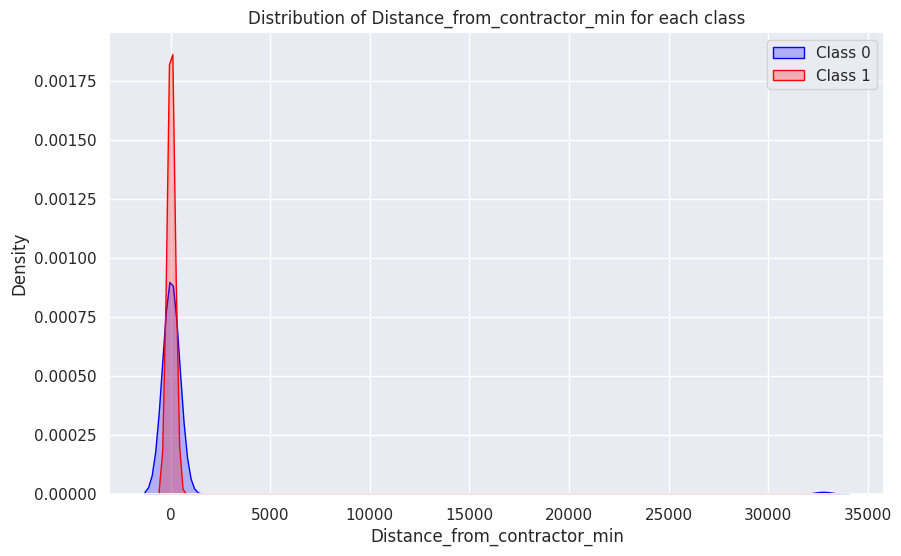

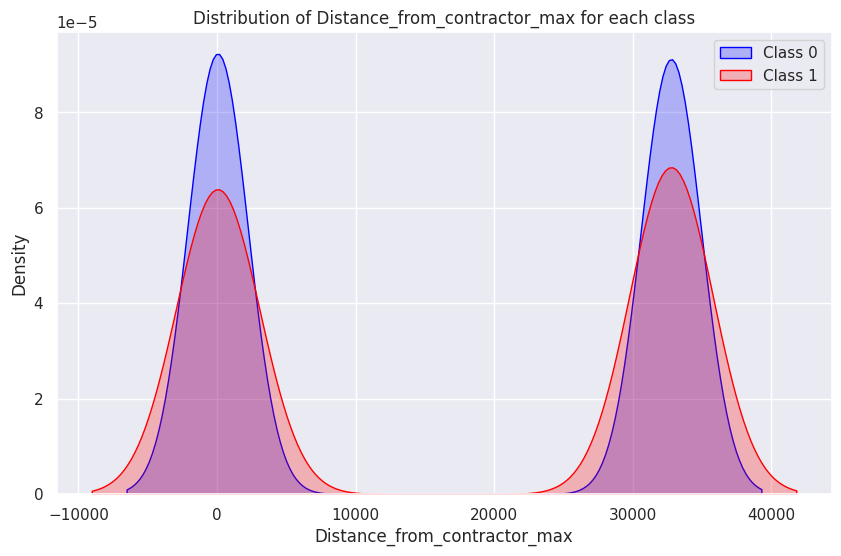

In [30]:
for i in dt.drop(columns=['default6']).columns:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(dt[dt['default6'] == 0][i], label='Class 0', fill=True, color='blue')
    sns.kdeplot(dt[dt['default6'] == 1][i], label='Class 1', fill=True, color='red')

    # Настройки графика
    plt.title(f'Distribution of {i} for each class')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### Итог:

#### -На графиках заметны различия распределений классов - значит фичи нам пригодятся

#### -Корреляции ненулевые, значит зависимость между дефолтом и связями графы существует

### Оставляем эти колонки

## Гипотеза №3: Использование временных колонок

### Подробнее о временных колонках читайте выше в функции "create_time_features"

In [31]:
"""
Создаем колонки по временым фичам:


    Кол-во рабочих
    Кол-во выходных
    Кол-во праздников
    Кол-во зимних дней
    Кол-во весених дней
    Кол-во осенних дней
    Кол-во летних дней
    Общая продолжительность контракта
"""

data = create_time_features(data, 'contract_date', 'report_date')
data = data.drop(columns=['date_range'])
data = data.sort_values('report_date')

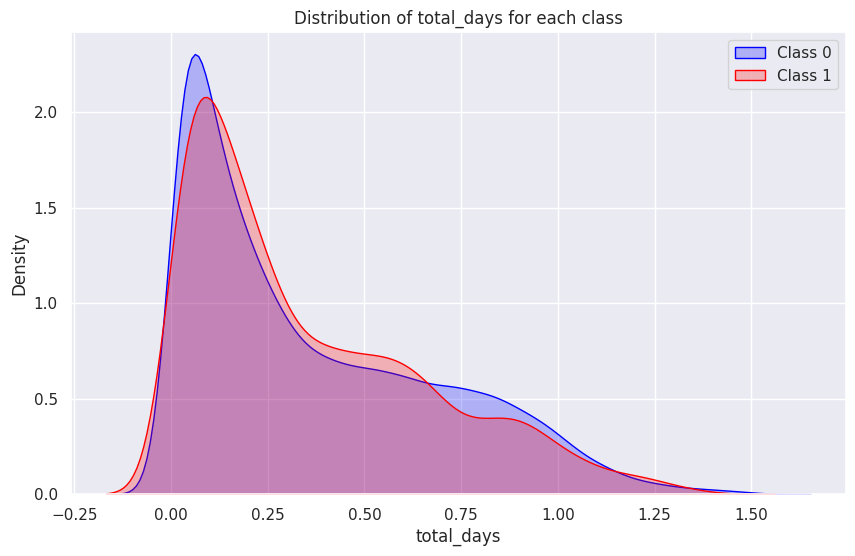

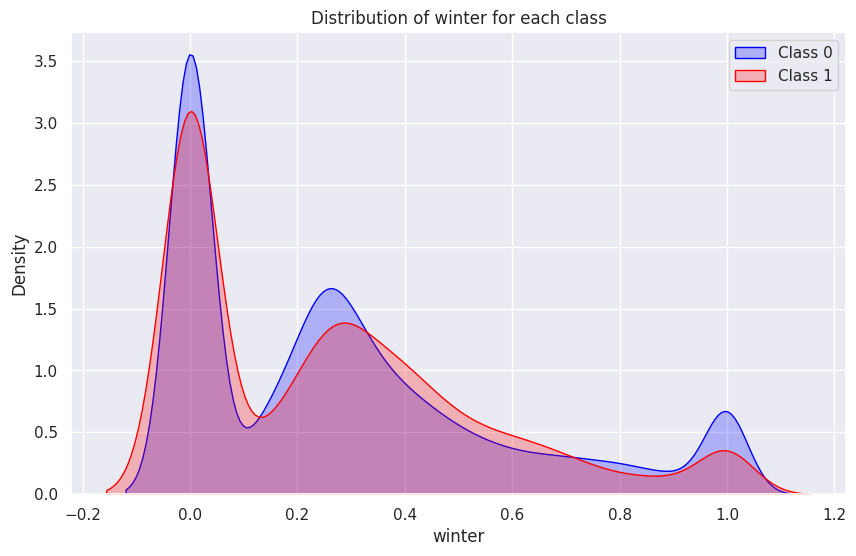

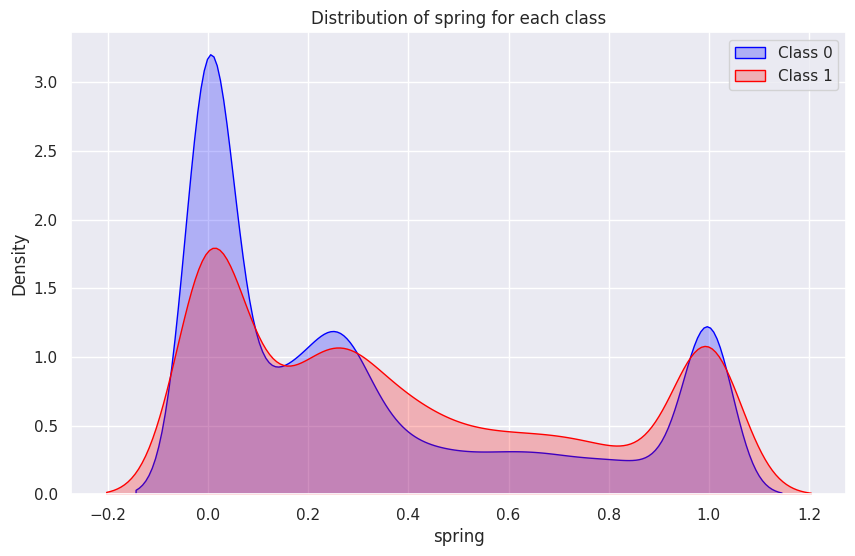

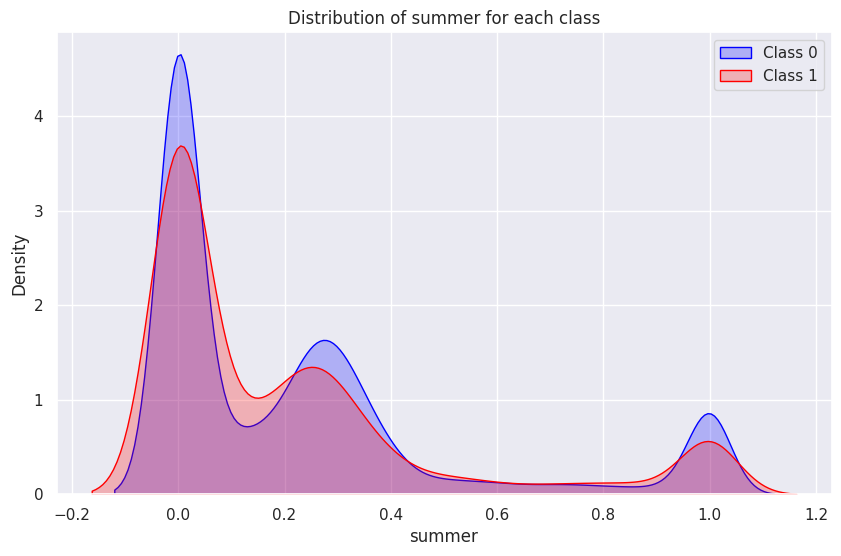

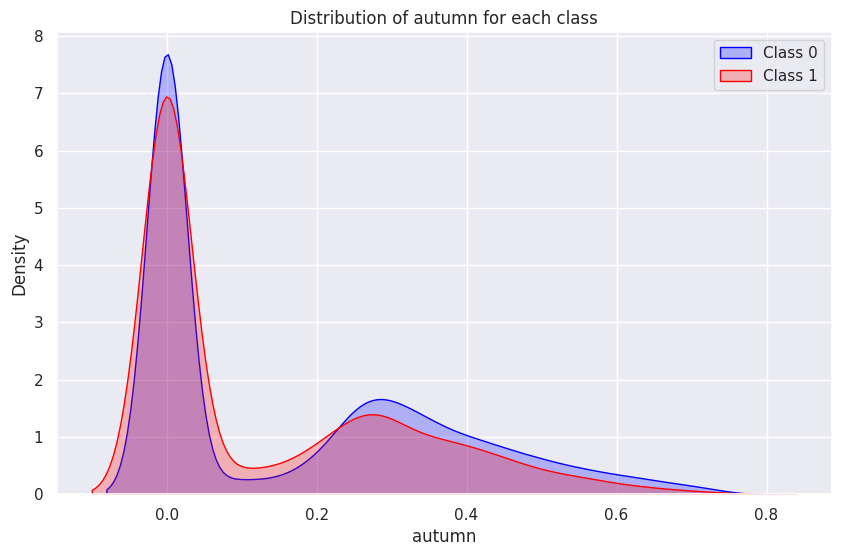

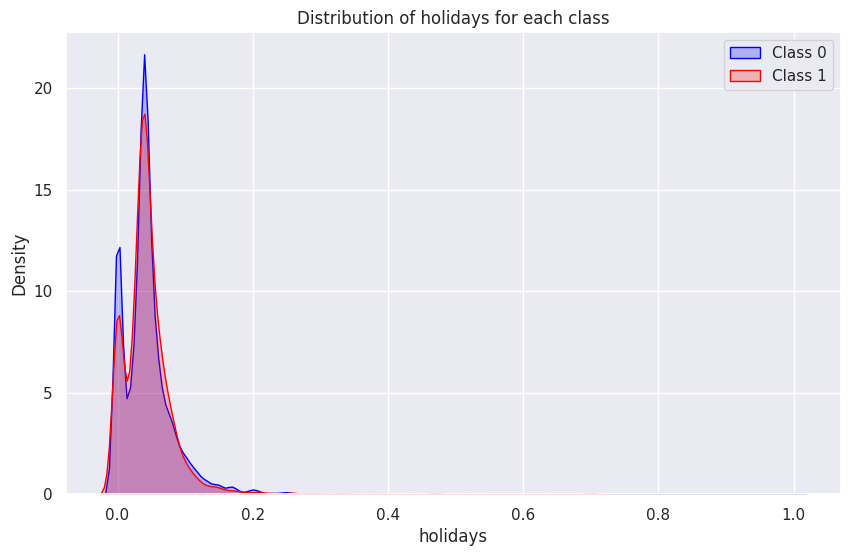

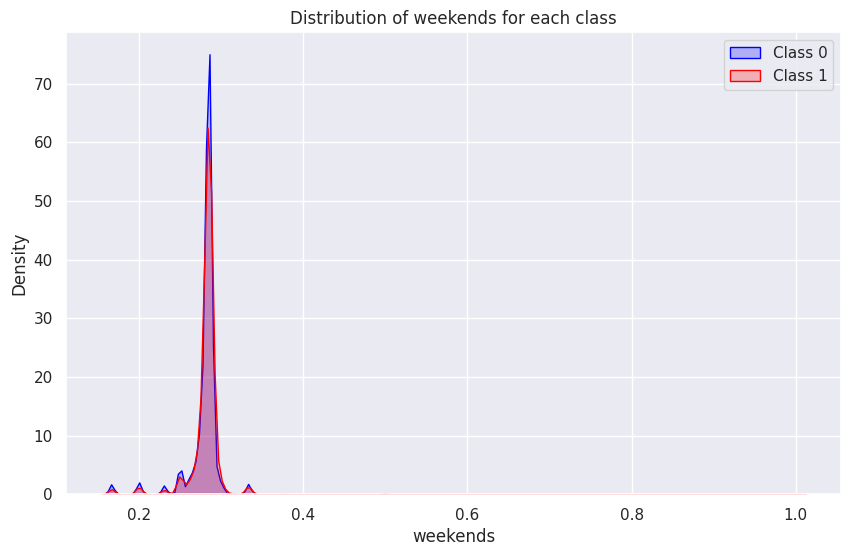

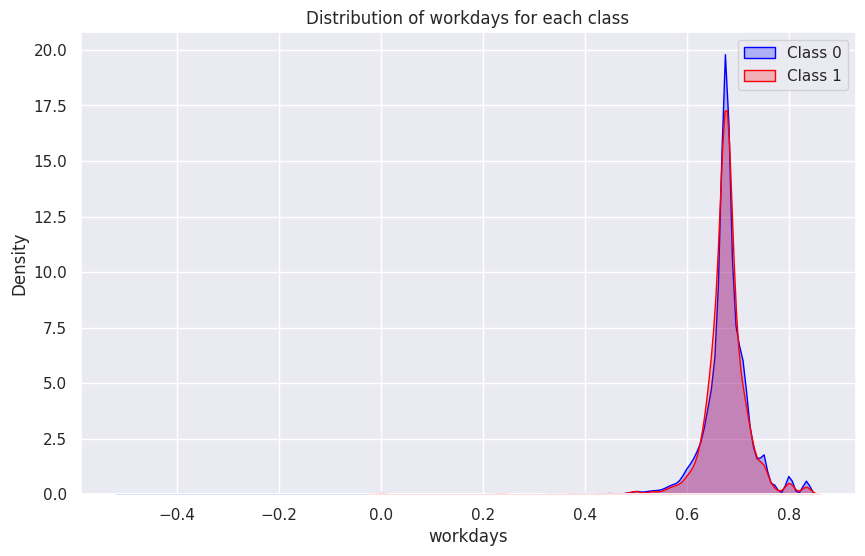

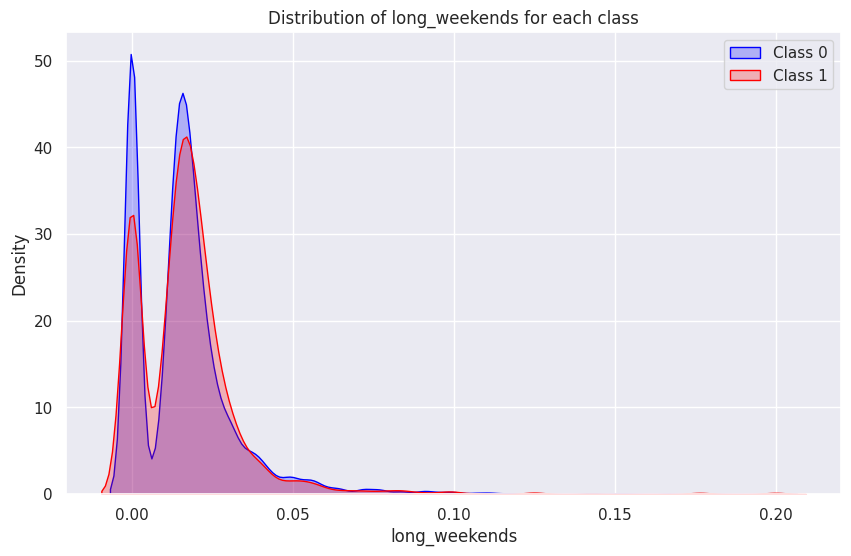

In [32]:
for i in data.iloc[:, -9:].columns:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(data[data['default6'] == 0][i], label='Class 0', fill=True, color='blue')
    sns.kdeplot(data[data['default6'] == 1][i], label='Class 1', fill=True, color='red')

    # Настройки графика
    plt.title(f'Distribution of {i} for each class')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### Заметим, что на графиках есть различия в распределении "дефолтных" значений (класс 1) и не "дефолтных", значит эти колонки точно помогут нам в задаче

## Гипотеза №4: Новые финансовые колонки

### Подробнее о новых колонках и их способе расчёта читайте выше, в функции "create_advanced_features"

In [33]:
data = create_advanced_features(data)

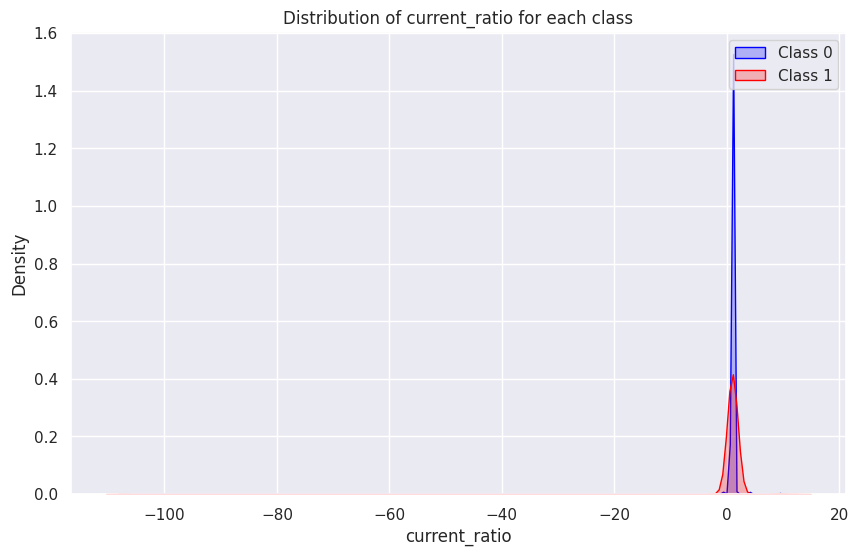

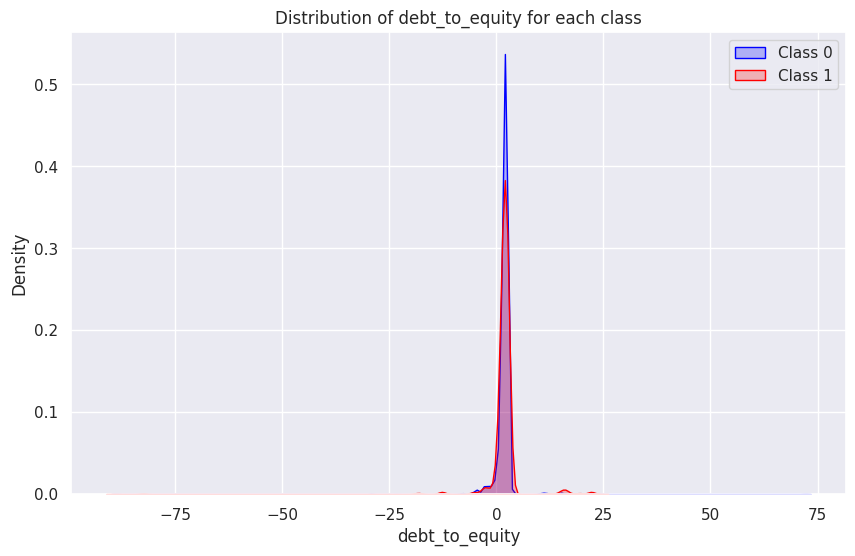

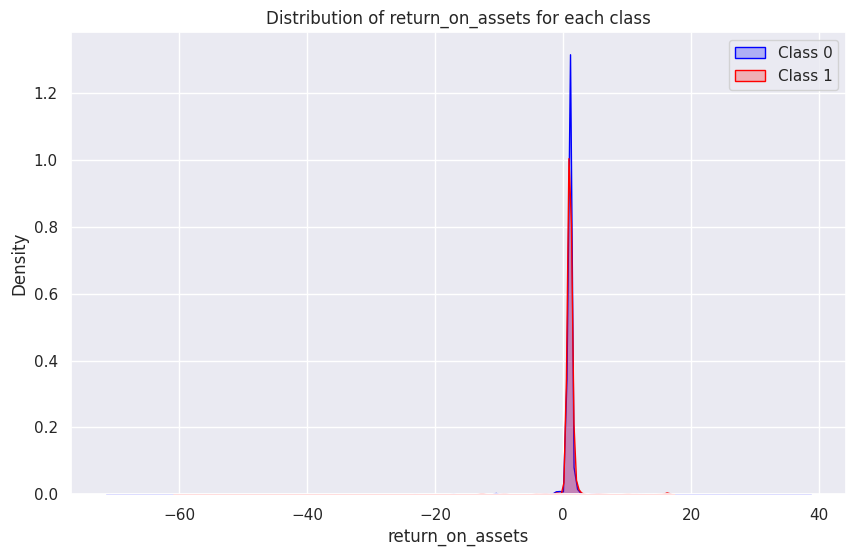

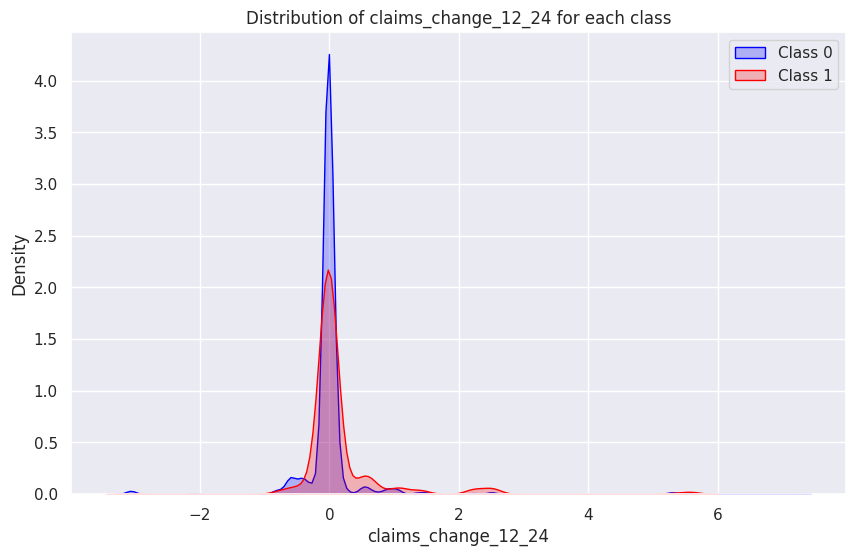

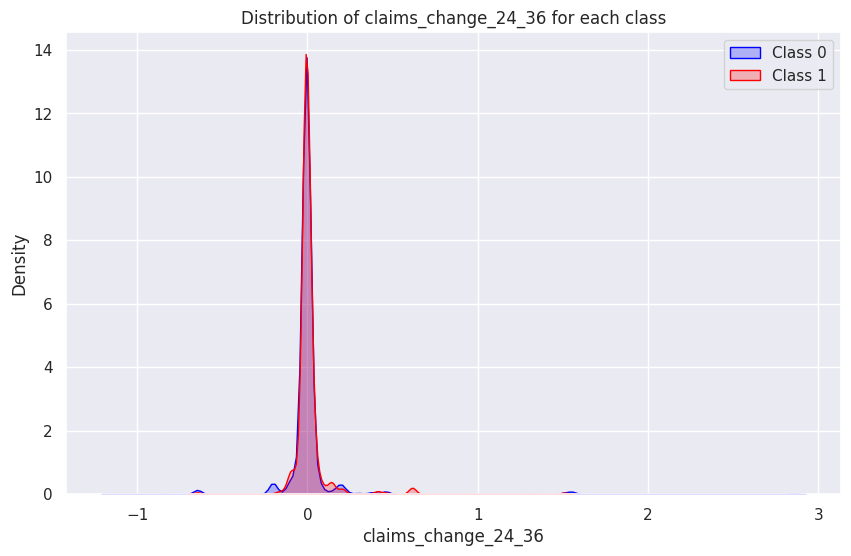

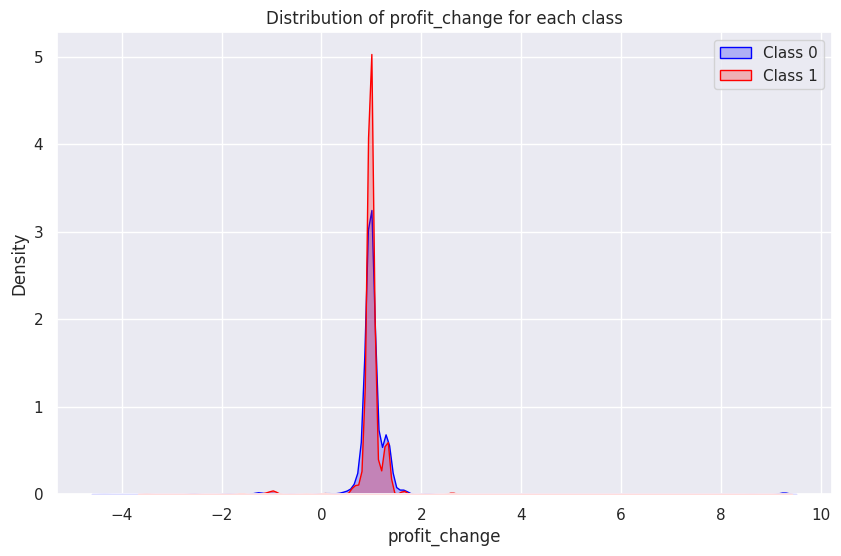

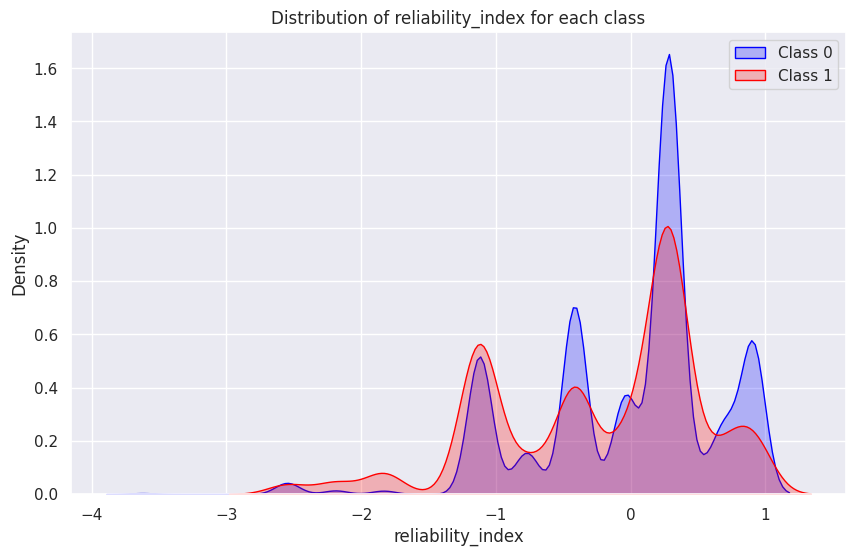

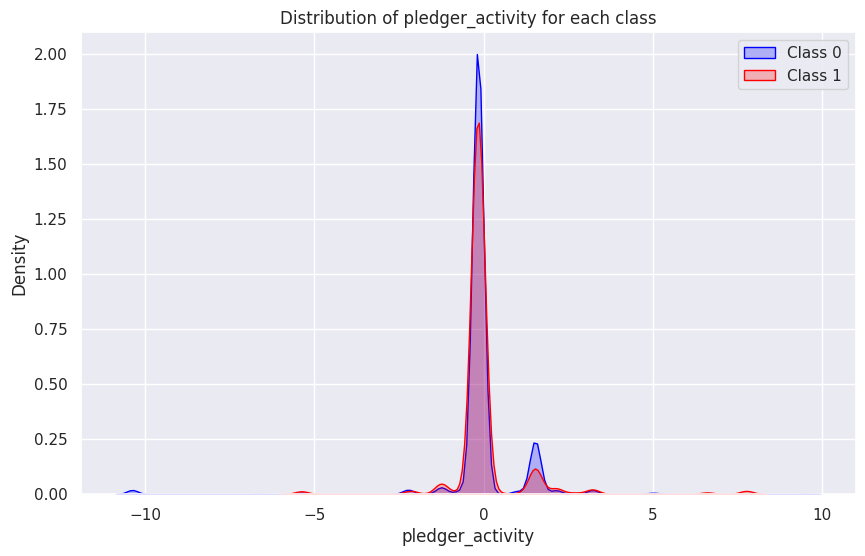

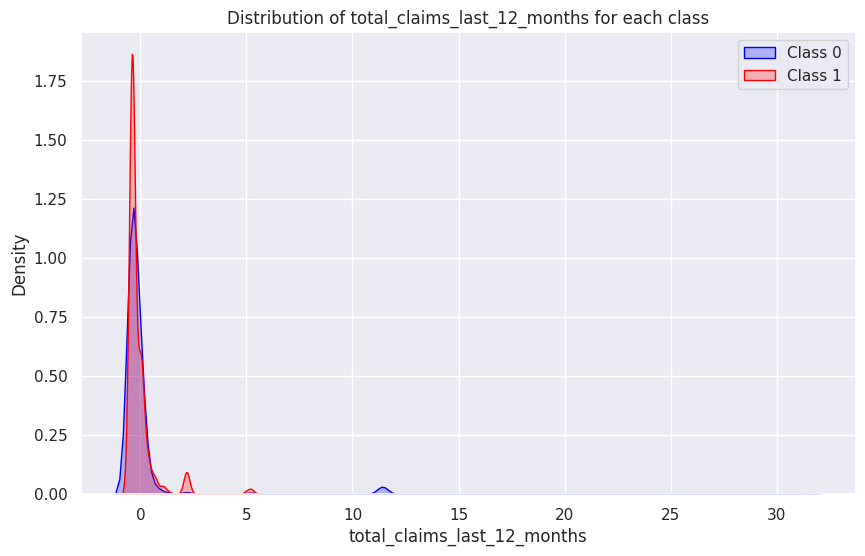

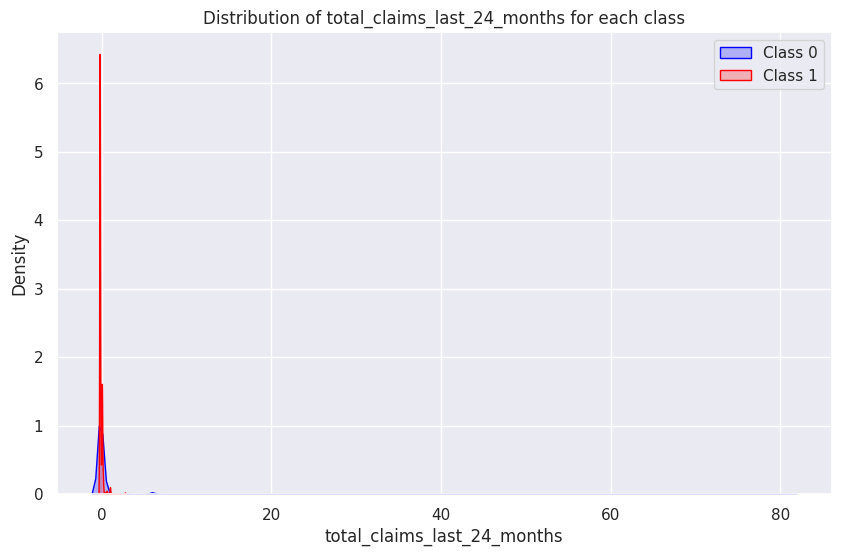

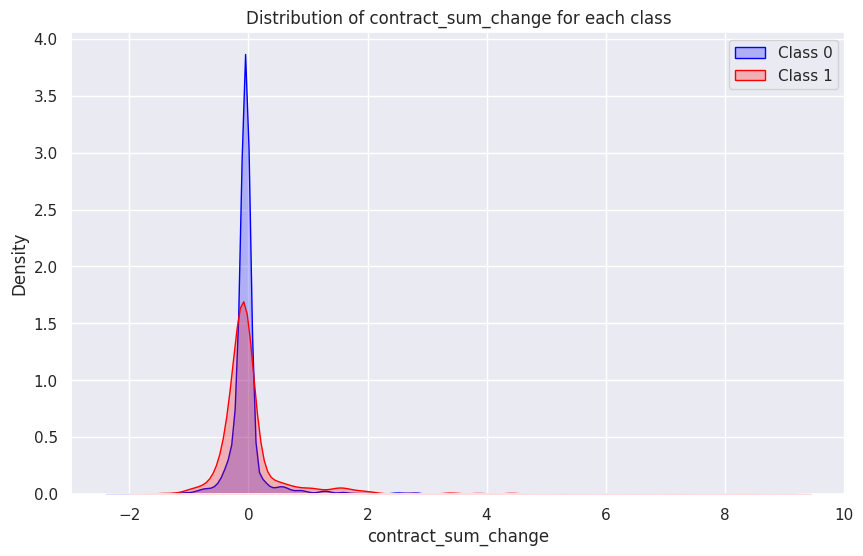

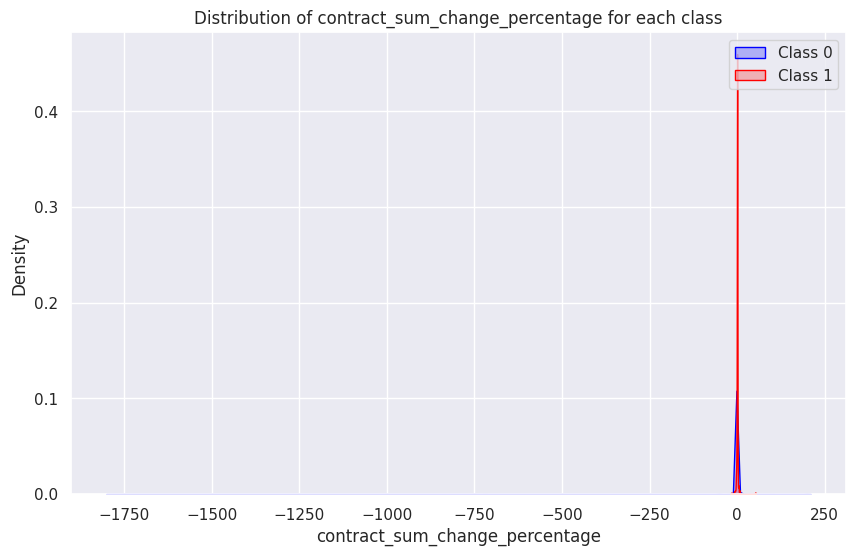

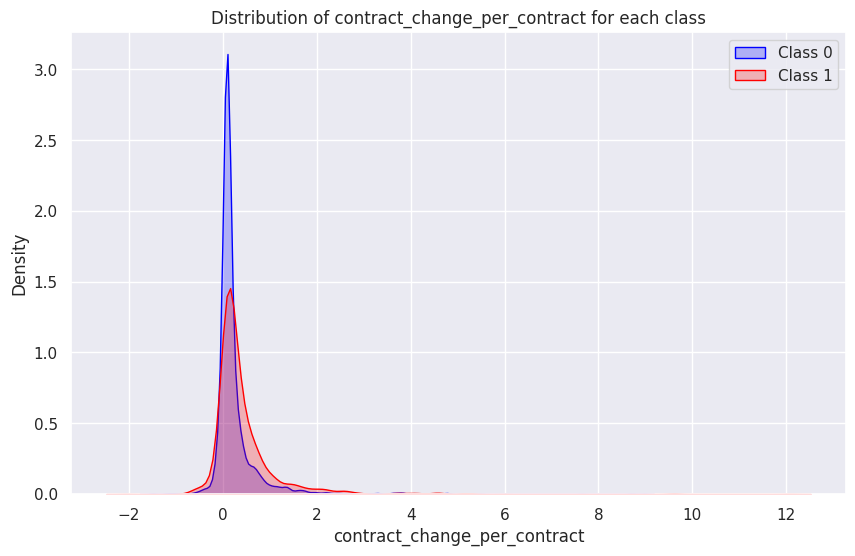

In [34]:
for i in data.iloc[:, -13:].columns:
    plt.figure(figsize=(10, 6))

    sns.kdeplot(data[data['default6'] == 0][i], label='Class 0', fill=True, color='blue')
    sns.kdeplot(data[data['default6'] == 1][i], label='Class 1', fill=True, color='red')

    # Настройки графика
    plt.title(f'Distribution of {i} for each class')
    plt.xlabel(i)
    plt.ylabel('Density')
    plt.legend()
    plt.grid(True)
    plt.show()

### На этих графиках также заметно различие распределений классов, что сопутствует улучшению вычисления вероятности дефолта

## Итог по гипотезам:

### -Мы оставляем все id для модели

### -Мы добавляем колонки графов, времени и новые финансовые колонки

## Получившийся датасет, уменьшаем расходуемую память, что поможет и при обучении и при хранении

In [35]:
data = reduce_mem_usage(data.drop(columns=['report_date', 'contract_date']))

Memory usage of dataframe is 43.55 MB
Memory usage after optimization is: 11.08 MB
Decreased by 74.6%


## Доработаем тест и применим на него обработку

In [36]:
test = create_time_features(test, 'contract_date', 'report_date')
test = test.drop(columns=['date_range', 'contract_id', 'contract_date', 'report_date'])
test = create_advanced_features(test)
test = work_graph(test, graph)
test = reduce_mem_usage(test)
test

Memory usage of dataframe is 19.66 MB
Memory usage after optimization is: 4.94 MB
Decreased by 74.9%


,specialization_id,contract_init_sum,project_id,building_id,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_cec_requests__g_contract__request_id__all__count__1W,agg_cec_requests__g_contract__request_id__all__count__2W,agg_cec_requests__g_contract__request_id__all__count__3W,...,Distance_to_contractor_mean,Distance_to_contractor_median,Distance_to_contractor_sum,Distance_to_contractor_count,Distance_from_contractor_min,Distance_from_contractor_max,Distance_from_contractor_mean,Distance_from_contractor_median,Distance_from_contractor_sum,Distance_from_contractor_count
0,15,-0.346924,42,84,637,-0.519531,-0.539062,-0.255859,-0.298828,-0.316650,...,511.50,24.0,206621.0,404.0,12.0,32768.0,103.375000,26.0,43426.0,420.0
1,11,-0.092957,44,727,637,-0.219238,-0.539062,-0.255859,-0.298828,-0.316650,...,511.50,24.0,206621.0,404.0,12.0,32768.0,103.375000,26.0,43426.0,420.0
2,15,-0.468018,44,728,637,-0.701660,-0.539062,-0.255859,-0.298828,-0.316650,...,511.50,24.0,206621.0,404.0,12.0,32768.0,103.375000,26.0,43426.0,420.0
3,15,-0.486816,44,727,637,-0.733398,-0.539062,-0.255859,-0.298828,-0.316650,...,511.50,24.0,206621.0,404.0,12.0,32768.0,103.375000,26.0,43426.0,420.0
4,11,-0.452637,42,85,637,-0.676758,-0.539062,-0.255859,-0.298828,-0.316650,...,511.50,24.0,206621.0,404.0,12.0,32768.0,103.375000,26.0,43426.0,420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,6,9.429688,5,401,327,2.154297,-0.539062,-0.255859,-0.298828,-0.316650,...,437.25,24.0,278125.0,636.0,12.0,45.0,24.750000,25.0,4430.0,179.0
13212,9,0.470703,28,204,327,0.300293,0.743652,-0.255859,0.021606,-0.085205,...,437.25,24.0,278125.0,636.0,12.0,45.0,24.750000,25.0,4430.0,179.0
13213,14,2.669922,16,915,52,1.115234,0.743652,0.276123,0.342041,0.377441,...,407.25,26.0,280197.0,688.0,14.0,52.0,28.953125,29.0,3561.0,123.0
13214,14,-0.420654,16,915,52,-0.626953,0.743652,-0.255859,-0.298828,-0.316650,...,407.25,26.0,280197.0,688.0,14.0,52.0,28.953125,29.0,3561.0,123.0


### Также для лучшего обучения модели проведём OHE (one hot encoding) с Id

In [37]:
data = pd.get_dummies(data, columns=['specialization_id', 'project_id', 'building_id', 'contractor_id'], dtype=int)
test = pd.get_dummies(test, columns=['specialization_id', 'project_id', 'building_id', 'contractor_id'], dtype=int)

In [38]:
data

,contract_id,contract_init_sum,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_cec_requests__g_contract__request_id__all__count__1W,agg_cec_requests__g_contract__request_id__all__count__2W,agg_cec_requests__g_contract__request_id__all__count__3W,agg_cec_requests__g_contract__request_id__all__count__4W,agg_cec_requests__g_contract__request_id__all__count__5W,agg_cec_requests__g_contract__request_id__all__count__6W,...,contractor_id_888,contractor_id_889,contractor_id_890,contractor_id_892,contractor_id_893,contractor_id_894,contractor_id_895,contractor_id_896,contractor_id_897,contractor_id_898
0,5433,1.115234,0.584473,-0.539062,-0.255859,0.342041,0.146118,0.221313,0.123291,0.185791,...,0,0,0,0,0,0,0,0,0,0
902,2162,-0.331055,-0.497803,-0.539062,-0.255859,-0.298828,-0.085205,-0.143433,-0.179443,-0.204224,...,0,0,0,0,0,0,0,0,0,0
901,5982,-0.347412,-0.520020,-0.539062,-0.255859,0.021606,0.146118,0.221313,0.123291,0.185791,...,0,0,0,0,0,0,0,0,0,0
900,6543,-0.322754,-0.486572,-0.539062,-0.255859,0.021606,0.146118,0.221313,0.123291,0.185791,...,0,0,0,0,0,0,0,0,0,0
899,1574,-0.313232,-0.474121,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28100,6281,-0.335205,-0.469971,2.027344,-0.255859,0.021606,-0.085205,-0.143433,-0.179443,0.315918,...,0,0,0,0,0,0,0,0,0,0
28099,4817,-0.120544,-0.247803,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,...,0,0,0,0,0,0,0,0,0,0
28098,6315,0.728027,0.389404,-0.539062,0.276123,0.021606,0.146118,0.038879,0.123291,0.055786,...,0,0,0,0,0,0,0,0,0,0
28104,73,-0.486084,-0.731934,-0.539062,0.276123,0.021606,-0.085205,-0.143433,-0.179443,-0.074219,...,0,0,0,0,0,0,0,0,0,0


In [39]:
test

,contract_init_sum,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_cec_requests__g_contract__request_id__all__count__1W,agg_cec_requests__g_contract__request_id__all__count__2W,agg_cec_requests__g_contract__request_id__all__count__3W,agg_cec_requests__g_contract__request_id__all__count__4W,agg_cec_requests__g_contract__request_id__all__count__5W,agg_cec_requests__g_contract__request_id__all__count__6W,agg_cec_requests__g_contract__request_id__all__count__7W,...,contractor_id_880,contractor_id_881,contractor_id_882,contractor_id_883,contractor_id_884,contractor_id_886,contractor_id_888,contractor_id_892,contractor_id_894,contractor_id_896
0,-0.346924,-0.519531,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0
1,-0.092957,-0.219238,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0
2,-0.468018,-0.701660,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0
3,-0.486816,-0.733398,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0
4,-0.452637,-0.676758,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,9.429688,2.154297,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0
13212,0.470703,0.300293,0.743652,-0.255859,0.021606,-0.085205,-0.143433,-0.179443,-0.074219,-0.107666,...,0,0,0,0,0,0,0,0,0,0
13213,2.669922,1.115234,0.743652,0.276123,0.342041,0.377441,0.221313,0.123291,0.185791,0.121399,...,0,0,0,0,0,0,0,0,0,0
13214,-0.420654,-0.626953,0.743652,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,0


### Заметим, что в тесте не хватает колонок, потому что каких либо подрядчиков и/или зданий, проектов, что есть в обучающем датасете нет в тесте

In [40]:
null_cols = set(data.columns) - set(test.columns)

In [41]:
len(null_cols)

500

In [42]:
all(['id' in x for x in null_cols if x != 'default6'])

True

In [43]:
test[list(null_cols)] = 0

In [44]:
len(set(data.columns) - set(test.columns))

0

## Отлично, теперь все колонки, что есть в train есть и в test

# Разделим датасет на фичи и целевую переменную, а также на тренировочный и валидационый набор даных

In [45]:
X = data.drop(columns=['default6'])
Y = data[['contract_id', 'default6']]

In [46]:
X

,contract_id,contract_init_sum,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_cec_requests__g_contract__request_id__all__count__1W,agg_cec_requests__g_contract__request_id__all__count__2W,agg_cec_requests__g_contract__request_id__all__count__3W,agg_cec_requests__g_contract__request_id__all__count__4W,agg_cec_requests__g_contract__request_id__all__count__5W,agg_cec_requests__g_contract__request_id__all__count__6W,...,contractor_id_888,contractor_id_889,contractor_id_890,contractor_id_892,contractor_id_893,contractor_id_894,contractor_id_895,contractor_id_896,contractor_id_897,contractor_id_898
0,5433,1.115234,0.584473,-0.539062,-0.255859,0.342041,0.146118,0.221313,0.123291,0.185791,...,0,0,0,0,0,0,0,0,0,0
902,2162,-0.331055,-0.497803,-0.539062,-0.255859,-0.298828,-0.085205,-0.143433,-0.179443,-0.204224,...,0,0,0,0,0,0,0,0,0,0
901,5982,-0.347412,-0.520020,-0.539062,-0.255859,0.021606,0.146118,0.221313,0.123291,0.185791,...,0,0,0,0,0,0,0,0,0,0
900,6543,-0.322754,-0.486572,-0.539062,-0.255859,0.021606,0.146118,0.221313,0.123291,0.185791,...,0,0,0,0,0,0,0,0,0,0
899,1574,-0.313232,-0.474121,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28100,6281,-0.335205,-0.469971,2.027344,-0.255859,0.021606,-0.085205,-0.143433,-0.179443,0.315918,...,0,0,0,0,0,0,0,0,0,0
28099,4817,-0.120544,-0.247803,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,...,0,0,0,0,0,0,0,0,0,0
28098,6315,0.728027,0.389404,-0.539062,0.276123,0.021606,0.146118,0.038879,0.123291,0.055786,...,0,0,0,0,0,0,0,0,0,0
28104,73,-0.486084,-0.731934,-0.539062,0.276123,0.021606,-0.085205,-0.143433,-0.179443,-0.074219,...,0,0,0,0,0,0,0,0,0,0


In [47]:
Y

,contract_id,default6
0,5433,0
902,2162,0
901,5982,0
900,6543,0
899,1574,0
...,...,...
28100,6281,0
28099,4817,0
28098,6315,0
28104,73,0


In [48]:
X = X.set_index('contract_id')
Y = Y.set_index('contract_id')

In [49]:
all_ids = np.unique(X.index)


train_ids, val_ids = train_test_split(
    all_ids,
    test_size=.255,
    shuffle=True,
    random_state=seed
)


train_x = X.loc[train_ids]
val_x = X.loc[val_ids]
train_y = Y.loc[train_ids]
val_y = Y.loc[val_ids]


X_train, X_valid, Y_train, Y_valid = train_x, val_x, train_y['default6'].to_numpy(), val_y['default6'].to_numpy()

In [50]:
len(X_train), len(X_valid)

(21585, 7246)

# Baseline (берём самую простую модель, чтобы бегло посмотреть на обучение)

## Посмотрим на модель без перебора

In [51]:
model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
model_lr.fit(X_train, Y_train)

LogisticRegression(class_weight='balanced', random_state=42)

In [52]:
lr_res = evaluate_models(
    models=[model_lr],
    model_names=['LogisticRegression'],
    X=X_valid,
    Y=Y_valid
)

lr_res

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,LogisticRegression,0.448937,0.263692,0.582248,0.170441,0.499045,-0.001909


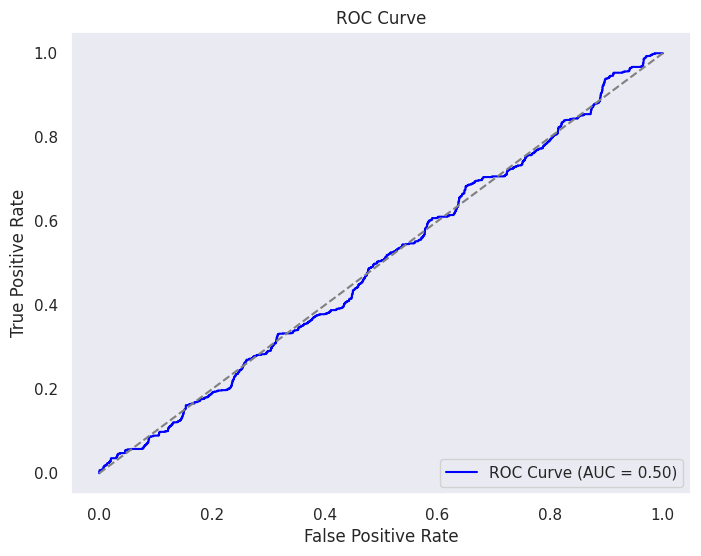

In [53]:
plot_roc_curve(model_lr, X_valid, Y_valid)

## Shap, который показывает значимость колонок для обучения

In [54]:
pd.DataFrame({
    'features': X.columns,
    'imp': model_lr.coef_[0]
}).sort_values('imp', ascending=False)

,features,imp
165,Distance_from_contractor_mean,0.001463
189,contract_sum_change_percentage,0.000665
94,agg_materials__g_contract__order_id__countDist...,0.000524
95,agg_materials__g_contract__order_id__countDist...,0.000503
93,agg_materials__g_contract__order_id__countDist...,0.000494
...,...,...
163,Distance_from_contractor_min,-0.000965
166,Distance_from_contractor_median,-0.001052
162,Distance_to_contractor_count,-0.001097
160,Distance_to_contractor_median,-0.001345


## Дообучим на всех данных

In [55]:
model_lr.fit(X.to_numpy(), Y['default6'].to_numpy())

kf = KFold(n_splits=6, shuffle=True, random_state=seed)
res_gini = []

for train_idxs, val_idxs in kf.split(all_ids):
    train_ids = all_ids[train_idxs]
    val_ids = all_ids[val_idxs]
    
    train_x = X.loc[train_ids]
    val_x = X.loc[val_ids]
    train_y = Y.loc[train_ids]['default6'].to_numpy()
    val_y = Y.loc[val_ids]['default6'].to_numpy()
    
    model = LogisticRegression(random_state=seed, class_weight='balanced')
    model.fit(train_x, train_y)

    gini = evaluate_models(
        models=[model],
        model_names=['LogisticRegression'],
        X=val_x,
        Y=val_y
    )['Gini']
    
    print(gini)
    res_gini.append(gini)
    

print(f'mean gini {np.mean(res_gini)}')

0    0.049006
Name: Gini, dtype: float64
0   -0.116971
Name: Gini, dtype: float64
0   -0.00072
Name: Gini, dtype: float64
0    0.055963
Name: Gini, dtype: float64
0   -0.045129
Name: Gini, dtype: float64
0   -0.080439
Name: Gini, dtype: float64
mean gini -0.02304837258292225


## Сабмит

In [ ]:
submit = pd.read_csv('data/test2_X.csv')[['contract_id', 'report_date']]
pred = model_lr.predict_proba(test[X.columns].to_numpy())
submit['score'] = pred[:, 1]
submit.to_csv('submit_model_lr_v1_aiijc-clio_v4.csv', index=False)

In [57]:
submit

,contract_id,report_date,score
0,3029,2023-07-30,0.496588
1,4350,2023-07-30,0.496605
2,1095,2023-07-30,0.496578
3,2634,2023-07-30,0.496577
4,6535,2023-07-30,0.496579
...,...,...,...
13211,650,2023-10-29,0.490472
13212,4277,2023-10-29,0.491175
13213,7316,2023-10-29,0.486284
13214,7113,2023-10-29,0.484210


## Эта модель крайне примитивна и поэтому не показала достойных результатов, но также заметим, что не все колонки важны для обучения, значит необходимо сделать их отсев

# Features Selection

## Первыми критериями отбора будут отклики 2-х моделей - RandomForest, LGBM <br> Сначала обучим их, а затем сохраним в датафреймах какие колонки им понадобились нужнее всего

## RandomForest Feature Selection

In [58]:
rfc = RandomForestClassifier(
    n_estimators=416,
    n_jobs=-1,
    random_state=seed
)
rfc.fit(X_train, Y_train)


rf_feature_importances = rfc.feature_importances_

rf_feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf_feature_importances
})

rf_feature_importance_df = rf_feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
rf_feature_importance_df

,Feature,Importance
0,contract_current_sum,0.019854
1,contract_change_per_contract,0.019632
2,contract_sum_change,0.018485
3,contract_sum_change_percentage,0.017150
4,contract_init_sum,0.016862
...,...,...
1508,building_id_810,0.000000
1509,building_id_813,0.000000
1510,building_id_820,0.000000
1511,building_id_821,0.000000


## LGBMClassifier Feature Selection

In [59]:
lgbm = LGBMClassifier(random_state=seed, verbose=-1, class_weight='balanced')
lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])


lgb_feature_importances = lgbm.feature_importances_
lgb_feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': lgb_feature_importances
})


lgb_feature_importance_df = lgb_feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
lgb_feature_importance_df

,Feature,Importance
0,contract_current_sum,125
1,contract_sum_change_percentage,102
2,contract_change_per_contract,74
3,contract_init_sum,59
4,agg_scontrol__g_contractor__close_delay__defec...,59
...,...,...
1508,building_id_571,0
1509,building_id_569,0
1510,building_id_567,0
1511,building_id_566,0


## Теперь используем один из методов отбора признаков - метод перемешивания или permutation_importance (модель для этого возьмём - catboost)

In [60]:
from sklearn.inspection import permutation_importance
from catboost import Pool


cat = CatBoostClassifier(random_state=seed, verbose=500, auto_class_weights='Balanced')
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))


result = permutation_importance(cat, X, Y, n_repeats=1, random_state=seed, n_jobs=-1)
perm_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': result.importances_mean
})

perm_importance_df = perm_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
perm_importance_df

Learning rate set to 0.067678
0:	learn: 0.6766651	test: 0.6826211	best: 0.6826211 (0)	total: 89.6ms	remaining: 1m 29s
500:	learn: 0.0906741	test: 0.7184066	best: 0.5691609 (84)	total: 15.9s	remaining: 15.9s
999:	learn: 0.0364070	test: 0.8720344	best: 0.5691609 (84)	total: 30.8s	remaining: 0us

bestTest = 0.5691609453
bestIteration = 84

Shrink model to first 85 iterations.


,Feature,Importance
0,contract_current_sum,0.011411
1,weekends,0.005550
2,agg_scontrol__g_contractor__close_delay__defec...,0.004891
3,agg_Finance__g_contractor__Value__Capital__las...,0.002948
4,winter,0.002914
...,...,...
1508,agg_spass_applications__g_contract__appl_count...,-0.001804
1509,contract_change_per_contract,-0.002116
1510,agg_spark_extended_report__g_contractor__Compa...,-0.002150
1511,counteragent_mean_agg_spass_applications__g_co...,-0.002150


## Ну и наконец последний критерий отбора - дерево объяснения линейных моделей - shap (за основу берём лог. регрессию)

In [61]:
model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
model_lr.fit(X_train, Y_train)


explainer = shap.LinearExplainer(model_lr, shap.maskers.Independent(X_train))
shap_values = explainer(X_valid)


shap_mean_importance = np.abs(shap_values.values).mean(axis=0)
shap_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': shap_mean_importance
})

shap_importance_df = shap_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

shap_importance_df

,Feature,Importance
0,Distance_from_contractor_sum,0.928672
1,Distance_from_contractor_mean,0.580700
2,Distance_to_contractor_sum,0.457004
3,Distance_to_contractor_median,0.395346
4,Distance_from_contractor_count,0.387477
...,...,...
1508,building_id_791,0.000000
1509,building_id_794,0.000000
1510,building_id_796,0.000000
1511,building_id_797,0.000000


## Пояснение о выборе критериев для Feature Selection:
## <br> Мы взяли отклики лучших моделей, а catboost, третью по точности модель решили использовать вместе с permutation importance, потому что бустинг catboost хорошо комбинируется с этим методом.<br> <br> Мы не использовали permutation importance на все модели сразу, так как каждая модель использует разные подходы к построению предсказаний, и, соответственно, их восприятие значимости признаков может отличаться. Если мы применяем permutation importance на наборе моделей сразу, мы можем получить усредненные или «смешанные» значения важности, которые не будут релевантными. <br><br> Для shap мы взяли Логистическую регрессию, так как она линейная и имеет возможность предсказания вероятности. <br> <br> Точности смотрите в таблице ниже.

## Собираем всё в единый датасет для отбора

In [62]:
df_imp = pd.DataFrame()
df_imp['cols'] = X.columns
df_imp['Rfc_imp'] = rfc.feature_importances_
df_imp['LGBM_imp'] = lgbm.feature_importances_
df_imp['perm_imp'] = result.importances_mean
df_imp['shap_imp'] = shap_mean_importance


rfc_rank = df_imp[['Rfc_imp', 'cols']].sort_values(by='Rfc_imp', ascending=False).reset_index(drop=True).reset_index()
rfc_rank = rfc_rank.rename(columns={'index': 'rfc_ind'})
rfc_rank['rfc_ind'] += 1
df_imp = df_imp.merge(rfc_rank)


LGBM_rank = df_imp[['LGBM_imp', 'cols']].sort_values(by='LGBM_imp', ascending=False).reset_index(drop=True).reset_index()
LGBM_rank = LGBM_rank.rename(columns={'index': 'LGBM_ind'})
LGBM_rank['LGBM_ind'] += 1
df_imp = df_imp.merge(LGBM_rank)


perm_rank = df_imp[['perm_imp', 'cols']].sort_values(by='perm_imp', ascending=False).reset_index(drop=True).reset_index()
perm_rank = perm_rank.rename(columns={'index': 'perm_ind'})
perm_rank['perm_ind'] += 1
df_imp = df_imp.merge(perm_rank)


shap_rank = df_imp[['shap_imp', 'cols']].sort_values(by='shap_imp', ascending=False).reset_index(drop=True).reset_index()
shap_rank = shap_rank.rename(columns={'index': 'shap_ind'})  # Изменим название на 'shap_ind'
shap_rank['shap_ind'] += 1

df_imp = df_imp.merge(shap_rank, on='cols', how='left')  # Объединим по столбцу 'cols'

### Пояснение к коду: здесь каждой колонке по каждому критерию присваивается индекс, чем он меньше тем колонка значимей, значит колонки с минимальным суммарным индексом - самые необходимые.

In [63]:
df_imp['full_imp'] = df_imp['rfc_ind'] + df_imp['LGBM_ind'] + df_imp['shap_ind'] + df_imp['perm_ind']
# df_imp['full_imp'] = df_imp['rfc_ind'] + df_imp['LGBM_ind'] + df_imp['shap_ind']

In [64]:
df_imp

,cols,Rfc_imp,LGBM_imp,perm_imp,shap_imp_x,rfc_ind,LGBM_ind,perm_ind,shap_ind,shap_imp_y,full_imp
0,contract_init_sum,1.686231e-02,59,-0.001075,2.726166e-04,5,4,1503,27,2.726166e-04,1539
1,contract_current_sum,1.985380e-02,125,0.011411,1.940153e-04,1,1,1,42,1.940153e-04,45
2,agg_all_contracts__g_contract__bit_da_guid__is...,2.221892e-03,4,-0.000243,2.494855e-05,126,170,1469,148,2.494855e-05,1913
3,agg_cec_requests__g_contract__request_id__all_...,7.121434e-04,0,0.000000,5.192175e-05,240,1101,1021,126,5.192175e-05,2488
4,agg_cec_requests__g_contract__request_id__all_...,1.263814e-03,0,0.000000,7.463804e-05,173,1100,1020,114,7.463804e-05,2407
...,...,...,...,...,...,...,...,...,...,...,...
1508,contractor_id_894,2.312059e-04,0,0.000000,3.399664e-07,377,671,560,237,3.399664e-07,1845
1509,contractor_id_895,1.197352e-06,0,0.000000,0.000000e+00,1011,670,559,919,0.000000e+00,3159
1510,contractor_id_896,0.000000e+00,0,0.000000,0.000000e+00,1244,669,558,920,0.000000e+00,3391
1511,contractor_id_897,3.957641e-08,0,0.000000,2.158448e-09,1182,668,557,643,2.158448e-09,3050


In [65]:
final_cols = df_imp.sort_values(by='full_imp').head(100)['cols'].tolist()

In [66]:
len(final_cols)

100

In [67]:
data[final_cols + ['default6', 'contract_id']]

,contract_sum_change_percentage,contract_current_sum,Distance_to_contractor_mean,Distance_to_contractor_sum,counteragent_mean_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME,total_claims_last_12_months,agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME,specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME,agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME,agg_materials__g_contract__material_id__countDistinct__ALL_TIME,...,contractor_id_851,contractor_id_47,contractor_id_218,agg_materials__g_contract__order_id__countDistinct__8W,contractor_id_745,contractor_id_793,contractor_id_63,contractor_id_282,default6,contract_id
0,-0.288086,0.584473,20.984375,1364.0,0.220459,0.134155,0.029938,-0.454346,-0.113770,6.113281,...,0,0,0,1.355469,0,0,0,0,0,5433
902,0.184204,-0.497803,657.000000,169449.0,-0.405518,-0.238037,-0.478027,-0.762207,-0.149414,-0.340332,...,0,0,0,-0.393799,0,0,0,0,0,2162
901,0.166992,-0.520020,657.000000,169449.0,-0.405518,-0.238037,0.063782,-0.762207,-0.149414,-0.263916,...,0,0,0,-0.284424,0,0,0,0,0,5982
900,0.193726,-0.486572,657.000000,169449.0,-0.405518,-0.238037,0.063782,-0.762207,-0.149414,-0.263916,...,0,0,0,-0.284424,0,0,0,0,0,6543
899,0.204956,-0.474121,657.000000,169449.0,-0.405518,-0.238037,-0.274902,-0.762207,-0.149414,-0.187622,...,0,0,0,-0.393799,0,0,0,0,0,1574
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28100,0.118774,-0.469971,433.250000,68884.0,-0.476318,-0.413818,-0.095520,-0.348877,-0.151855,-0.187622,...,0,0,0,-0.393799,0,0,0,0,0,6281
28099,0.820312,-0.247803,433.250000,68884.0,-0.476318,-0.413818,-0.884277,-0.478271,-0.151855,-0.302002,...,0,0,0,0.043640,0,0,0,0,0,4817
28098,-0.345703,0.389404,644.000000,238254.0,0.861328,-0.410645,0.044434,2.326172,-0.150269,0.576172,...,0,0,0,3.761719,0,0,0,0,0,6315
28104,0.068176,-0.731934,366.500000,277350.0,-0.035400,-0.413818,-0.245728,-0.479736,-0.143311,-0.340332,...,0,0,0,-0.393799,0,0,0,0,0,73


In [68]:
final_cols

['contract_sum_change_percentage',
 'contract_current_sum',
 'Distance_to_contractor_mean',
 'Distance_to_contractor_sum',
 'counteragent_mean_agg_ks2__g_contract__total_sum__all__sum__ALL_TIME',
 'total_claims_last_12_months',
 'agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME',
 'specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME',
 'agg_materials__g_contract__material_id__countDistinct__ALL_TIME',
 'agg_spass_applications__g_contract__appl_count_week__mean__26W',
 'claims_change_12_24',
 'reliability_index',
 'Distance_from_contractor_median',
 'spring',
 'agg_payments__g_contract__sum__all__sum__ALL_TIME',
 'agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME',
 'contract_sum_change',
 'agg_scontrol__g_contractor__close_delay__defect_type_tech_supervision__mean__ALL_TIME',
 'counteragent_sum_agg_cec_requests__g_contract__total_sum_accepted__all__sum__ALL_TIME

## Заново создаём выборки для обучения и теперь нужно отобрать лучшую модель

In [69]:
X = data[final_cols + ['contract_id']]
Y = data[['default6', 'contract_id']]


X = X.set_index('contract_id')
Y = Y.set_index('contract_id')


all_ids = np.unique(X.index)


train_ids, val_ids = train_test_split(
    all_ids,
    test_size=.255,
    shuffle=True,
    random_state=seed
)


train_x = X.loc[train_ids]
val_x = X.loc[val_ids]
train_y = Y.loc[train_ids]
val_y = Y.loc[val_ids]


X_train, X_valid, Y_train, Y_valid = train_x, val_x, train_y['default6'].to_numpy(), val_y['default6'].to_numpy()

In [70]:
X.shape, X_train.shape, X_valid.shape

((28831, 100), (21585, 100), (7246, 100))

# Выбор модели

### Обучаем различные модели

In [71]:
model_lr = LogisticRegression(random_state=seed, class_weight='balanced')
model_lr.fit(X_train, Y_train)

rfc = RandomForestClassifier(random_state=seed, class_weight='balanced')
rfc.fit(X_train, Y_train)

dtc = DecisionTreeClassifier(random_state=seed, class_weight='balanced')
dtc.fit(X_train, Y_train)

sgd = SGDClassifier(random_state=seed, loss='log_loss', class_weight='balanced')
sgd.fit(X_train, Y_train)

mlpc = MLPClassifier(random_state=seed)
mlpc.fit(X_train, Y_train)

cat = CatBoostClassifier(use_best_model=True, random_state=seed, verbose=500, auto_class_weights='Balanced')
cat.fit(X_train, Y_train, eval_set=(X_valid, Y_valid))

xgb = XGBClassifier(random_state=seed, class_weight='balanced')
xgb.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)], verbose=10)

lgbm = LGBMClassifier(random_state=seed, verbose=-1, class_weight='balanced')
lgbm.fit(X_train, Y_train, eval_set=[(X_valid, Y_valid)])

Learning rate set to 0.067678
0:	learn: 0.6783264	test: 0.6837211	best: 0.6837211 (0)	total: 27.7ms	remaining: 27.7s
500:	learn: 0.0664960	test: 0.8209152	best: 0.5874363 (88)	total: 10.9s	remaining: 10.9s
999:	learn: 0.0221747	test: 1.0529850	best: 0.5874363 (88)	total: 17.7s	remaining: 0us

bestTest = 0.5874363132
bestIteration = 88

Shrink model to first 89 iterations.
[0]	validation_0-logloss:0.44636
[10]	validation_0-logloss:0.41828
[20]	validation_0-logloss:0.41991
[30]	validation_0-logloss:0.41625
[40]	validation_0-logloss:0.41751
[50]	validation_0-logloss:0.42508
[60]	validation_0-logloss:0.43840
[70]	validation_0-logloss:0.44705
[80]	validation_0-logloss:0.45798
[90]	validation_0-logloss:0.47225
[99]	validation_0-logloss:0.48541


LGBMClassifier(class_weight='balanced', random_state=42, verbose=-1)

In [72]:
evaluate_models(
    models=[model_lr, cat, xgb, lgbm, rfc, dtc, sgd, mlpc],
    model_names=['LogisticRegression', 'CatBoostClassifier', 'XGBClassifier',
                 'LGBMClassifier', 'RandomForestClassifier', 'DecisionTreeClassifier',
                 'SGDClassifier', 'MLPClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,LogisticRegression,0.662986,0.346709,0.527687,0.258167,0.624141,0.248282
1,CatBoostClassifier,0.786227,0.472591,0.565147,0.406085,0.786284,0.572568
2,XGBClassifier,0.835495,0.327314,0.236156,0.533088,0.783281,0.566562
3,LGBMClassifier,0.820039,0.459370,0.451140,0.467905,0.792322,0.584643
4,RandomForestClassifier,0.842258,0.246539,0.152280,0.647059,0.794663,0.589326
5,DecisionTreeClassifier,0.776014,0.313161,0.301303,0.325991,0.587092,0.174184
6,SGDClassifier,0.786779,0.070956,0.048046,0.135632,0.492783,-0.014434
7,MLPClassifier,0.821833,0.065170,0.036645,0.294118,0.483744,-0.032513


### Итак, лучшей моделью оказался RandomForest по метрике gini, поэтому его и оставим

# Обучение лучшей модели

In [73]:
rfc = RandomForestClassifier(
    n_estimators=416,
    n_jobs=-1,
    random_state=seed
)

rfc.fit(X_train, Y_train)

evaluate_models(
    models=[rfc],
    model_names=['RandomForestClassifier'],
    X=X_valid,
    Y=Y_valid
)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,RandomForestClassifier,0.839084,0.281134,0.185668,0.57868,0.805578,0.611157


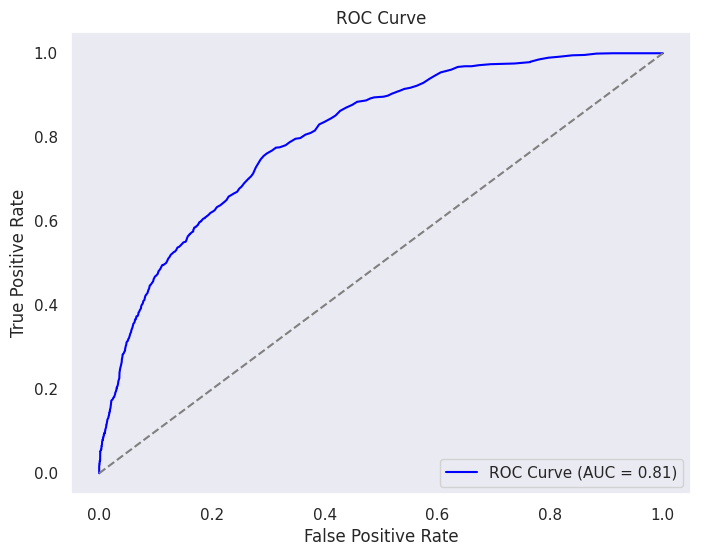

In [74]:
plot_roc_curve(rfc, X_valid, Y_valid)

## Важный этап обучения - валидация, которая поможет проверить модель на переобучение

In [75]:
kf = KFold(n_splits=6, shuffle=True, random_state=seed)
res_gini = []

for train_idxs, val_idxs in kf.split(all_ids):
    train_ids = all_ids[train_idxs]
    val_ids = all_ids[val_idxs]
    
    train_x = X.loc[train_ids]
    val_x = X.loc[val_ids]
    train_y = Y.loc[train_ids]['default6'].to_numpy()
    val_y = Y.loc[val_ids]['default6'].to_numpy()
    
    model = RandomForestClassifier(
        n_estimators=416,
        n_jobs=-1,
        random_state=seed
    )
    model.fit(train_x, train_y)

    gini = evaluate_models(
        models=[model],
        model_names=['RandomForestClassifier'],
        X=val_x,
        Y=val_y
    )['Gini']
    
    print(gini)
    res_gini.append(gini)
    
print(f'mean gini {np.mean(res_gini)}')

0    0.647374
Name: Gini, dtype: float64
0    0.621692
Name: Gini, dtype: float64
0    0.571444
Name: Gini, dtype: float64
0    0.563176
Name: Gini, dtype: float64
0    0.677694
Name: Gini, dtype: float64
0    0.478126
Name: Gini, dtype: float64
mean gini 0.5932511289021738


### Заметим, что метрика каждой части отклоняется от средней не более, чем на 0.1, что показывает низкую степень переобученности модели

## Оптимизация гиперпараметров

In [76]:
from sklearn.metrics import log_loss

def fit_rfc(trial, train, val):
    X_train, y_train = train
    X_val, y_val = val


    param = {
        "n_estimators" : trial.suggest_int('n_estimators', 200, 512),
        "criterion": trial.suggest_categorical("criterion", ["gini", "entropy"]),
        "max_depth": trial.suggest_int("max_depth", 4, 32)
    }
    

    clf = RandomForestClassifier(**param, n_jobs=-1, random_state=seed)
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_val)[:, 1]
    return clf, y_pred


def objective(trial, return_models=False):
    model, y_pred = fit_rfc(trial, (X_train, Y_train), (X_valid, Y_valid))
    result =  2 * roc_auc_score(Y_valid, y_pred) - 1
    if return_models:
        return result, model
    else:
        return result

In [77]:
study = optuna.create_study(direction="minimize")
study.optimize(objective,
               n_trials=30,
               show_progress_bar=True,)

[I 2024-11-13 19:08:37,942] A new study created in memory with name: no-name-61bd0f49-4638-46be-9e24-b76163e11e59


  0%|          | 0/30 [00:00<?, ?it/s]

[I 2024-11-13 19:08:53,721] Trial 0 finished with value: 0.5652364296902994 and parameters: {'n_estimators': 379, 'criterion': 'gini', 'max_depth': 9}. Best is trial 0 with value: 0.5652364296902994.
[I 2024-11-13 19:09:16,647] Trial 1 finished with value: 0.6072458520204858 and parameters: {'n_estimators': 336, 'criterion': 'entropy', 'max_depth': 25}. Best is trial 0 with value: 0.5652364296902994.
[I 2024-11-13 19:09:29,064] Trial 2 finished with value: 0.5887017286901512 and parameters: {'n_estimators': 214, 'criterion': 'gini', 'max_depth': 14}. Best is trial 0 with value: 0.5652364296902994.
[I 2024-11-13 19:09:54,538] Trial 3 finished with value: 0.6161580405363711 and parameters: {'n_estimators': 393, 'criterion': 'entropy', 'max_depth': 17}. Best is trial 0 with value: 0.5652364296902994.
[I 2024-11-13 19:10:13,541] Trial 4 finished with value: 0.6058782122687312 and parameters: {'n_estimators': 260, 'criterion': 'gini', 'max_depth': 28}. Best is trial 0 with value: 0.56523642

### Мы получили лучшие параметры, теперь обучим модель с ними

In [78]:
study.best_trial.params

{'n_estimators': 304, 'criterion': 'entropy', 'max_depth': 4}

In [79]:
params = study.best_trial.params
params['n_jobs'] = -1
params['random_state'] = seed

In [80]:
params

{'n_estimators': 304,
 'criterion': 'entropy',
 'max_depth': 4,
 'n_jobs': -1,
 'random_state': 42}

In [81]:
rfc = RandomForestClassifier(
     **study.best_trial.params)

In [82]:
rfc.fit(X_train, Y_train)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=304)

In [83]:
evaluate_models(
     models=[rfc],
     model_names=['RandomForestClassifier'],
     X=X_valid,
     Y=Y_valid)

,Model,Accuracy,F1 Score,Recall,Precision,ROC AUC,Gini
0,RandomForestClassifier,0.830527,0.0,0.0,0.0,0.738485,0.476971


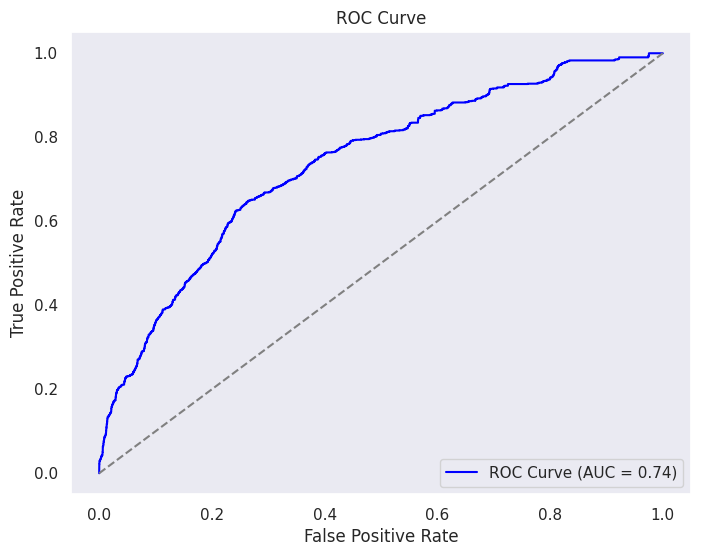

In [84]:
plot_roc_curve(rfc, X_valid, Y_valid)

In [85]:
kf = KFold(n_splits=6, shuffle=True, random_state=seed)
res_gini = []

for train_idxs, val_idxs in kf.split(all_ids):
    train_ids = all_ids[train_idxs]
    val_ids = all_ids[val_idxs]
    

    train_x = X.loc[train_ids]
    val_x = X.loc[val_ids]
    train_y = Y.loc[train_ids]['default6'].to_numpy()
    val_y = Y.loc[val_ids]['default6'].to_numpy()
    

    model = RandomForestClassifier(
        **study.best_trial.params
    )
    model.fit(train_x, train_y)


    gini = evaluate_models(
        models=[model],
        model_names=['RandomForestClassifier'],
        X=val_x,
        Y=val_y
    )['Gini']
    print(gini)
    res_gini.append(gini)
print(f'mean gini {np.mean(res_gini)}')

0    0.546446
Name: Gini, dtype: float64
0    0.376612
Name: Gini, dtype: float64
0    0.49322
Name: Gini, dtype: float64
0    0.389324
Name: Gini, dtype: float64
0    0.526156
Name: Gini, dtype: float64
0    0.293212
Name: Gini, dtype: float64
mean gini 0.4374950836206673


In [86]:
rfc.fit(
    X,
    Y['default6'].to_numpy()
)

RandomForestClassifier(criterion='entropy', max_depth=4, n_estimators=304)

In [87]:
filename = "RandomForestClassifier_scoring.pickle"
pickle.dump(rfc, open(filename, "wb"))

# Интерпретация

In [88]:
def explanation_col_normalizer(condition):
        """
        Converts lime's as_list() column names to normal output: (column_name, more_than, less_than) as more_than < column_name < less_than 
        Returns more_than and less_than are float values or None if inf
        """
        pattern = r'(((?P<conv_1>-?\d*\.?\d*)\s*(?P<sign_1>(<=|>=|>|<)))?\s*(?P<column>\w+)\s*((?P<sign_2>(<=|>=|>|<))\s*(?P<conv_2>-?\d*\.?\d*))?)'
        match = re.search(pattern, condition)
        if match:
            conv1 = match.group('conv_1')
            sign1 = match.group('sign_1')
            conv2 = match.group('conv_2')
            sign2 = match.group('sign_2')
            column_name = match.group('column')
            more_than = -np.inf
            less_than = np.inf
            if sign1 in ['<', '<=']:
                if conv1 == None or conv1 == '':
                    conv1 = float("-inf")
                else:
                    conv1 = float(conv1)
                more_than = max(more_than, conv1)
            elif sign1 in ['>', '>=']:
                if conv1 == None or conv1 == '':
                    conv1 = float("inf")
                else:
                    conv1 = float(conv1)
                less_than = min(less_than, conv1)
            if sign2 in ['<', '<=']:
                if conv2 == None or conv2 == '':
                    conv2 = float("inf")
                else:
                    conv2 = float(conv2)
                less_than = min(less_than, conv2)
            elif sign2 in ['>', '>=']:
                if conv2 == None or conv2 == '':
                    conv2 = float("-inf")
                else:
                    conv2 = float(conv2)
                more_than = max(more_than, conv2)
            if more_than == float("-inf"):
                more_than = None
            if less_than == float("inf"):
                less_than = None
            return (column_name, more_than, less_than)
        else:
            return ("", None, None)

    
def filter_explanation_columns(col_name: str):
    return not col_name.startswith(("contractor_id", "building_id", "project_id", "specialization_id"))


def explanation_to_dict(exp, row: pd.Series, final_cols) -> dict:
        vals = row[list(filter(filter_explanation_columns, final_cols))].to_dict()
        predict = exp.predict_proba
        contract_id = row['contract_id']
        report_date = row['report_date']
        def expli_mapper(x):
            nm = explanation_col_normalizer(x[0])
            return {
                "column_name": nm[0],
                "more_than": nm[1],
                "less_than": nm[2],
                "importance": x[1]
            }
        cols_list = exp.as_list()
        cols_list = list(filter(lambda x: filter_explanation_columns(x['column_name']), map(lambda x: expli_mapper(x), cols_list)))
        for cd in cols_list:
            cd['real_value'] = vals[cd['column_name']]
        exp_dict = {
            "contract_id": contract_id,
            "report_date": report_date,
            "predict_score_negative": predict[0],
            "predict_score_positive": predict[1],
            "columns_explanation": cols_list
        }
        return exp_dict


def generate_explanation_text(exp_dict: dict) -> str:
        positive_explanations = []
        negative_explanations = []
        columns_explanation = sorted(exp_dict['columns_explanation'], key=lambda x: x['importance'], reverse=True)
        if len(columns_explanation) > 10:
            columns_explanation = columns_explanation[:5] + columns_explanation[-5:]
        for column in columns_explanation:
            column_name = column['column_name']
            more_than = column['more_than']
            less_than = column['less_than']
            importance = column['importance']
            real_value = column['real_value']
            if more_than is not None and less_than is not None:
                explanation = f"{column_name}, потому что значение столбца {real_value:.2f} находится в промежутке от {more_than:.2f} до {less_than:.2f}"
            elif more_than is not None:
                explanation = f"{column_name}, потому что значение столбца {real_value:.2f} {'больше или равно' if f'{real_value:.2f}' == f'{more_than:.2f}' else 'больше чем' } {more_than:.2f}"
            elif less_than is not None:
                explanation = f"{column_name}, потому что значение столбца {real_value:.2f} {'меньше или равно' if f'{real_value:.2f}' == f'{less_than:.2f}' else 'меньше чем' } {less_than:.2f}"
            else:
                explanation = ""
            if importance > 0:
                positive_explanations.append(explanation)
            else:
                negative_explanations.append(explanation)
        explanation_text = "Самыми важными колонками за увеличение вероятности дефолта были:\n"
        explanation_text += "\n".join(f"{i + 1}) {explanation}" for i, explanation in enumerate(positive_explanations))
        explanation_text += "\n\nА самыми важными против вероятности дефолта:\n"
        explanation_text += "\n".join(f"{i + 1}) {explanation}" for i, explanation in enumerate(negative_explanations))
        return explanation_text


def explain_row(explainer, rfc, final_cols, row: pd.Series) -> dict:
    exp = explainer.explain_instance(row[final_cols].values, rfc.predict_proba, num_features=len(final_cols))
    return generate_explanation_text(explanation_to_dict(exp, row, final_cols))


def explain_all_line(explainer, rfc, final_cols, rows):
    explains = []
    for i in tqdm(range(len(rows))):
        explains.append(explain_row(explainer, rfc, final_cols, rows.iloc[i]))
    return explains

### Этот скрипт выполняет генерацию текстовых объяснений на основе моделей машинного обучения с помощью библиотеки LIME для интерпретации предсказаний. Основная цель — преобразовать полученные от модели интерпретации признаков в человекочитаемый текст, который может объяснить факторы, способствующие (или препятствующие) дефолту.

In [ ]:
from lime.lime_tabular import LimeTabularExplainer  # Импортируем класс LimeTabularExplainer из библиотеки lime для интерпретации моделей
import pandas as pd

# Создаем объект LimeTabularExplainer для объяснения предсказаний модели
explainer = LimeTabularExplainer(
    training_data=test[final_cols].to_numpy(),  # Используем данные из тестовой выборки для обучения интерпретатора
    feature_names=final_cols,                   # Указываем имена признаков, чтобы интерпретатор мог использовать их для объяснений
)

# Загружаем дополнительный файл данных, содержащий колонки contract_id и report_date
date_col = pd.read_csv('data/test2_X.csv')[['report_date']]

# Объединяем test и date_col по столбцу 'contract_id' методом right join
test_with_date = test.join(date_col)

# Выводим размерности DataFrame до и после объединения для проверки корректности слияния
print(*test.shape)
print(*test_with_date.shape)

13216 1978
13216 1979


In [90]:
test_with_date

,contract_init_sum,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_cec_requests__g_contract__request_id__all__count__1W,agg_cec_requests__g_contract__request_id__all__count__2W,agg_cec_requests__g_contract__request_id__all__count__3W,agg_cec_requests__g_contract__request_id__all__count__4W,agg_cec_requests__g_contract__request_id__all__count__5W,agg_cec_requests__g_contract__request_id__all__count__6W,agg_cec_requests__g_contract__request_id__all__count__7W,...,building_id_574,building_id_161,building_id_94,contractor_id_839,building_id_509,contractor_id_495,contractor_id_741,contractor_id_390,contractor_id_377,report_date
0,-0.346924,-0.519531,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-07-30
1,-0.092957,-0.219238,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-07-30
2,-0.468018,-0.701660,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-07-30
3,-0.486816,-0.733398,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-07-30
4,-0.452637,-0.676758,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-07-30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,9.429688,2.154297,-0.539062,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-10-29
13212,0.470703,0.300293,0.743652,-0.255859,0.021606,-0.085205,-0.143433,-0.179443,-0.074219,-0.107666,...,0,0,0,0,0,0,0,0,0,2023-10-29
13213,2.669922,1.115234,0.743652,0.276123,0.342041,0.377441,0.221313,0.123291,0.185791,0.121399,...,0,0,0,0,0,0,0,0,0,2023-10-29
13214,-0.420654,-0.626953,0.743652,-0.255859,-0.298828,-0.316650,-0.325928,-0.330811,-0.334229,-0.336670,...,0,0,0,0,0,0,0,0,0,2023-10-29


In [91]:
print(explain_row(explainer, rfc, final_cols, test_with_date.loc[0]))

Самыми важными колонками за увеличение вероятности дефолта были:
1) Distance_to_contractor_sum, потому что значение столбца 206621.00 находится в промежутке от 136569.00 до 237838.00
2) winter, потому что значение столбца 0.00 меньше или равно 0.00
3) agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME, потому что значение столбца 0.61 больше чем -0.04
4) weekends, потому что значение столбца 0.17 меньше чем 0.27
5) agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME, потому что значение столбца -0.12 больше чем -0.14

А самыми важными против вероятности дефолта:
1) contract_sum_change_percentage, потому что значение столбца 0.17 больше чем 0.14
2) reliability_index, потому что значение столбца 0.29 находится в промежутке от -0.42 до 0.29
3) agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME, потому что значение столбца -0.88 меньше чем -0.48
4) specialization_sum_agg_payments__g_contract__sum__all__sum__ALL_TIME, 

In [92]:
len(test_with_date)

13216

In [93]:
# генерируем интерпретации
explanations = explain_all_line(explainer, rfc, final_cols, test_with_date)

100%|██████████| 13216/13216 [1:12:15<00:00,  3.05it/s]


In [94]:
print(explanations[0])

Самыми важными колонками за увеличение вероятности дефолта были:
1) agg_spass_applications__g_contract__appl_count_week__mean__26W, потому что значение столбца -0.86 меньше или равно -0.86
2) Distance_to_contractor_sum, потому что значение столбца 206621.00 находится в промежутке от 136569.00 до 237838.00
3) agg_spark_extended_report__g_contractor__CreditLimitSum__last__ALL_TIME, потому что значение столбца -0.12 больше чем -0.14
4) agg_scontrol__g_contractor__close_delay__defect_type_labour_protection__mean__ALL_TIME, потому что значение столбца 0.61 больше чем -0.04
5) agg_ArbitrationCases__g_contractor__DefendantSum__sum__ALL_TIME, потому что значение столбца -0.17 меньше или равно -0.17

А самыми важными против вероятности дефолта:
1) claims_change_12_24, потому что значение столбца -0.04 меньше или равно -0.04
2) contract_sum_change_percentage, потому что значение столбца 0.17 больше чем 0.14
3) agg_spass_applications__g_contract__appl_count_week__mean__ALL_TIME, потому что значен

### Мы сгенерировали интерпретации в удобном для пользователя виде, теперь мы можем добавить их к сабмиту

# Предсказание

In [ ]:
submit = pd.read_csv('data/test2_X.csv')[['contract_id', 'report_date']]
pred = rfc.predict_proba(test[final_cols])[:, 1]
submit['score'] = pred
# добавляем интерпретации
submit['interpretation'] = explanations
submit.to_csv('submit_model_rfc_m4_1.csv', index=False)

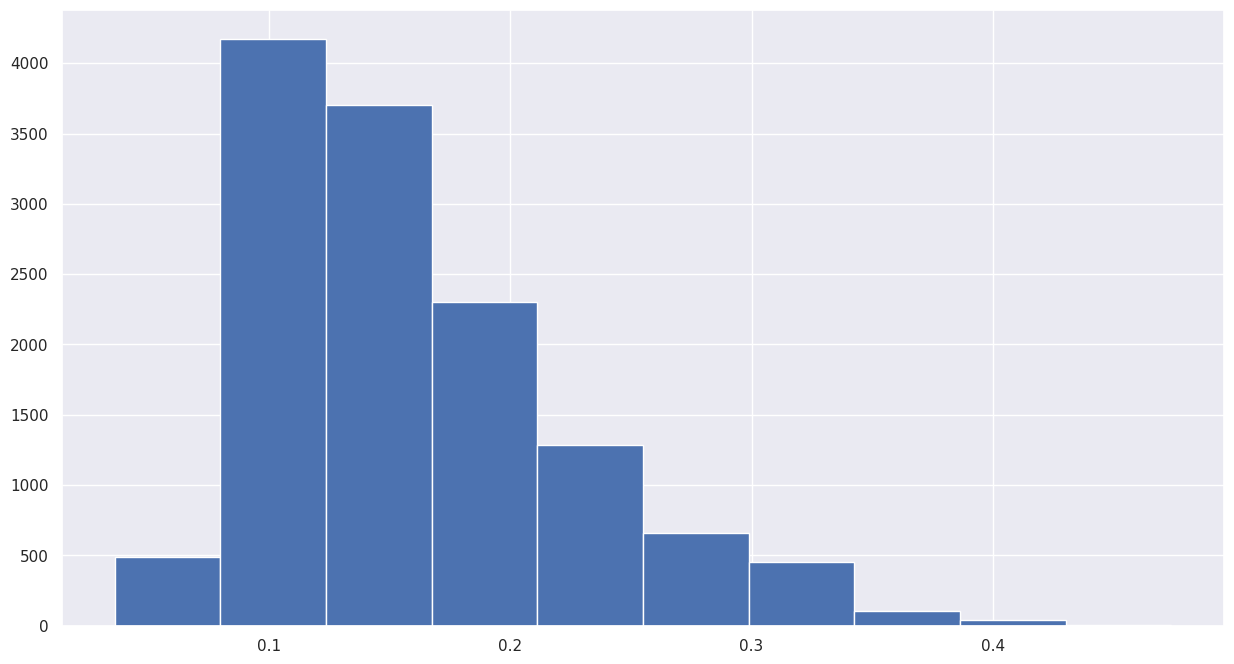

In [96]:
submit['score'].hist();

In [97]:
submit

,contract_id,report_date,score,interpretation
0,3029,2023-07-30,0.103136,Самыми важными колонками за увеличение вероятн...
1,4350,2023-07-30,0.120203,Самыми важными колонками за увеличение вероятн...
2,1095,2023-07-30,0.099603,Самыми важными колонками за увеличение вероятн...
3,2634,2023-07-30,0.106548,Самыми важными колонками за увеличение вероятн...
4,6535,2023-07-30,0.102039,Самыми важными колонками за увеличение вероятн...
...,...,...,...,...
13211,650,2023-10-29,0.189888,Самыми важными колонками за увеличение вероятн...
13212,4277,2023-10-29,0.233937,Самыми важными колонками за увеличение вероятн...
13213,7316,2023-10-29,0.266224,Самыми важными колонками за увеличение вероятн...
13214,7113,2023-10-29,0.157316,Самыми важными колонками за увеличение вероятн...


# Попробуем сделать блендинг

### Используем стабильные бустинги XGB и Cat Boost, LGBM зачастую завышает и/или занижает вероятность

In [98]:
cat = CatBoostClassifier(
    random_seed=seed,
    auto_class_weights='Balanced'
)

cat.fit(X, Y['default6'].to_numpy(), verbose=100)

Learning rate set to 0.043281
0:	learn: 0.6835544	total: 21ms	remaining: 21s
100:	learn: 0.4165755	total: 1.59s	remaining: 14.2s
200:	learn: 0.3169008	total: 3.17s	remaining: 12.6s
300:	learn: 0.2467985	total: 4.7s	remaining: 10.9s
400:	learn: 0.1939693	total: 6.25s	remaining: 9.33s
500:	learn: 0.1584940	total: 7.76s	remaining: 7.73s
600:	learn: 0.1307745	total: 9.27s	remaining: 6.16s
700:	learn: 0.1095064	total: 10.8s	remaining: 4.61s
800:	learn: 0.0928021	total: 12.3s	remaining: 3.06s
900:	learn: 0.0801159	total: 13.8s	remaining: 1.52s
999:	learn: 0.0694632	total: 15.4s	remaining: 0us


In [99]:
filename = "CatBoostClassifier_scoring.pickle"
pickle.dump(cat, open(filename, "wb"))

In [100]:
xgb = XGBClassifier(
    random_state=seed,
    class_weight='balanced'
)

xgb.fit(X, Y['default6'], verbose=32)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              class_weight='balanced', colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

In [101]:
filename = "XGBClassifier_scoring.pickle"
pickle.dump(xgb, open(filename, "wb"))

In [ ]:
submit = pd.read_csv('data/test2_X.csv')[['contract_id', 'report_date']]
pred = rfc.predict_proba(test[final_cols])[:, 1] * 0.9 + xgb.predict_proba(test[final_cols])[:, 1] * 0.05 + cat.predict_proba(test[final_cols])[:, 1] * 0.05
submit['score'] = pred
submit['interpretation'] = explanations
submit.to_csv('model_rfc_m4_BLEND_Selection_graph.csv', index=False)

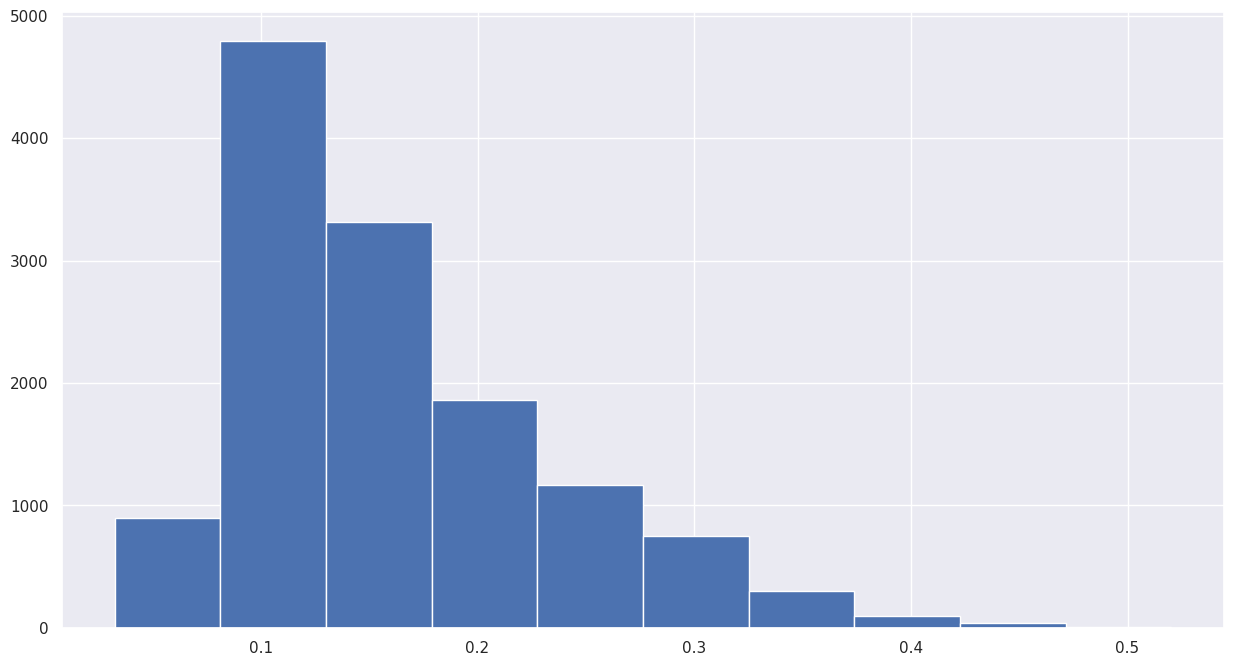

In [103]:
submit['score'].hist();

In [104]:
submit

,contract_id,report_date,score,interpretation
0,3029,2023-07-30,0.096477,Самыми важными колонками за увеличение вероятн...
1,4350,2023-07-30,0.115950,Самыми важными колонками за увеличение вероятн...
2,1095,2023-07-30,0.093608,Самыми важными колонками за увеличение вероятн...
3,2634,2023-07-30,0.101604,Самыми важными колонками за увеличение вероятн...
4,6535,2023-07-30,0.094887,Самыми важными колонками за увеличение вероятн...
...,...,...,...,...
13211,650,2023-10-29,0.174391,Самыми важными колонками за увеличение вероятн...
13212,4277,2023-10-29,0.213334,Самыми важными колонками за увеличение вероятн...
13213,7316,2023-10-29,0.249060,Самыми важными колонками за увеличение вероятн...
13214,7113,2023-10-29,0.151028,Самыми важными колонками за увеличение вероятн...


### Блендинг - распространённая практика в машинном обучении, которая улучшает точность

# Сделаем подкрепляющую модель

### Подкрепляющей моделью будет RandomForestClassifier, обученный на данных без повторений по contract, contractor и project ID. <br> Мы решили, что так как модель будет дополнять вероятности именно по взаимодействию контракторов (читайте ниже про идею), то нужно обучить её на данных без повторений.

### Идея:



### Мы провели глубокий анализ взаимосвязей в графе контракторов и решили, что интересной и полезной идеей будет брать в качестве ответа максимум из предсказанной вероятности для данного контракта и основного контрактора и предсказанной вероятности для данного контракта и другого контрактора, близкого к основному контрактору по графу. <br> Почему же можно считать релевантным подходом поиск близкого контрактора - потому что они похожи и это поможет сделать вероятность более точной. Иными словами мы хотим обобщить с какой вероятностью близкие компании выполнят этот контракт

### Вторая трактовка идеи: <br> Если мы хотим сделать вероятность наиболее точной (обобщённой) - нам необходимо, чтобы и предсказывалось она для как можно более близких контракторов

## Предобработка

In [105]:
graph

,contractor_id1,contractor_id2,Distance
0,599,215,26
1,884,653,18
2,731,391,27
3,136,113,28
4,231,266,20
...,...,...,...
327181,106,441,14
327182,21,48,30
327183,504,480,20
327184,649,853,31


### Создаём таблицу взаимодействий контракторов из графа для реализации идеи

In [ ]:
data_sub = pd.read_csv('data/train_X.csv')
test_sub = pd.read_csv('data/test2_X.csv')


train_y = pd.read_csv('data/train_y.csv')
data_sub['default6'] = train_y['default6']

### Скачиваем датасеты и убираем пропуски

In [107]:
data_del_par, nan_par = [], []
for i in data_sub.isnull().sum().items():
    if i[-1] > len(data_sub) * 0.7:        
        data_del_par.append(i[0])
    if 0 < i[-1] <= len(data_sub) * 0.7:       
        nan_par.append(i[0])


data_sub = data_sub.drop(columns=data_del_par)
imputer = MeanMedianImputer(imputation_method='median', variables=nan_par)
imputer.fit(data_sub[nan_par])
data_sub[nan_par] = imputer.transform(data_sub[nan_par])

### Минимально предобрабатываем данные, чтобы модель более широко обобщала задачу

In [108]:
# unic_data - набор с уникальными контрактами
unic_data = data_sub.drop(columns=['report_date', 'contract_date']).drop_duplicates(subset=['contract_id', 'contractor_id', 'default6']).groupby(['contract_id', 'contractor_id', 'specialization_id', 'project_id'], as_index=False).mean()
unic_data['default6'] = unic_data['default6'].apply(lambda x: 1 if x > 0.5 else 0)
unic_data = unic_data.drop(columns=['contract_id','project_id', 'building_id'])
unic_data.fillna(0, inplace=True)
unic_data

,contractor_id,specialization_id,contract_init_sum,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_cec_requests__g_contract__request_id__all__count__1W,agg_cec_requests__g_contract__request_id__all__count__2W,agg_cec_requests__g_contract__request_id__all__count__3W,agg_cec_requests__g_contract__request_id__all__count__4W,agg_cec_requests__g_contract__request_id__all__count__5W,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME,default6
0,47,20,-0.000596,-0.121085,-0.539030,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
1,474,14,-0.515778,-0.383474,0.743673,0.808046,0.341961,0.146159,0.038888,-0.028058,...,-0.158464,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
2,500,12,-0.515778,0.168862,0.743673,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
3,784,9,0.607576,0.377632,-0.539030,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
4,532,3,-0.511846,-0.540323,-0.539030,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3443,98,13,-0.318884,-0.382089,-0.539030,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158473,-0.136894,0.287916,2.031532,1.047594,1.874863,0.970040,0.841839,0.838176,0
3444,489,19,-0.348542,-0.402243,0.743673,-0.255766,-0.298754,-0.085207,-0.143490,-0.179385,...,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,1
3445,511,14,-0.515778,-0.519796,0.743673,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,0
3446,894,13,-0.014982,-0.132882,-0.539030,-0.255766,-0.298754,-0.316572,-0.325867,-0.330712,...,-0.158464,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454,1


### Как раз таки убираем дубликаты и удаляем все id, чтобы модель опять же более широко смотрела на задачу, а именно усредняем контракты с одинаковыми id

In [109]:
unic_test = test_sub.copy()
unic_test = unic_test.drop(columns=['contract_id','project_id', 'building_id'])
unic_test[nan_par] = imputer.transform(unic_test[nan_par])
unic_test.fillna(0, inplace=True)
unic_test

,report_date,specialization_id,contract_init_sum,contract_date,contractor_id,contract_current_sum,agg_all_contracts__g_contract__bit_da_guid__isMain__count__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__last__ALL_TIME,agg_all_contracts__g_contract__abs_change_price_last_ds__isMain__mean__ALL_TIME,agg_all_contracts__g_contract__rel_change_price_last_ds__isMain__last__ALL_TIME,...,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__12_48M,agg_ArbitrationCases__g_contractor__PlaintiffSum__sum__ALL_TIME,agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__12W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W,agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME
0,2023-07-30,15,-0.347029,2023-07-24 21:00:00,637,-0.405169,-0.539030,0.000000,0.000000,0.000000,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
1,2023-07-30,11,-0.092977,2023-07-11 21:00:00,637,-0.196840,-0.539030,0.000000,0.000000,0.000000,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
2,2023-07-30,15,-0.467957,2023-07-24 21:00:00,637,-0.504333,-0.539030,0.000000,0.000000,0.000000,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
3,2023-07-30,15,-0.486723,2023-07-24 21:00:00,637,-0.519721,-0.539030,0.000000,0.000000,0.000000,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
4,2023-07-30,11,-0.452585,2023-07-27 21:00:00,637,-0.491727,-0.539030,0.000000,0.000000,0.000000,...,-0.158471,-0.158473,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13211,2023-10-29,6,9.432208,2023-10-14 21:00:00,327,7.614058,-0.539030,0.000000,0.000000,0.000000,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13212,2023-10-29,9,0.470615,2023-03-06 21:00:00,327,0.350311,0.743673,-0.283382,-0.315768,-0.073783,...,-0.158468,-0.158467,-0.136894,-0.157822,-0.178045,-0.190966,-0.200348,-0.225724,-0.256704,-0.258454
13213,2023-10-29,14,2.669630,2023-08-15 21:00:00,52,2.051660,0.743673,-0.425980,-0.464945,-0.082025,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767
13214,2023-10-29,14,-0.420756,2023-08-15 21:00:00,52,-0.465753,0.743673,-0.402493,-0.440374,-0.081666,...,-0.158471,-0.158474,-0.136894,-0.157822,-0.178045,-0.190966,-0.166329,-0.206438,-0.238986,-0.240767


### Мы используем для вторичной модели те же предобработки, что и для нашей модели на прошлом этапе, а именно нормализация специализации делением на 100 и удалением части колонок (Для основной модели есть Feature selection, чтобы удалять ненужное)

In [110]:
del_col = ['project_id', 'building_id', 'contractor_id',
           'agg_BoardOfDirectors__g_contractor__Name__count__ALL_TIME',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__1M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__2M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__3M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__4M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__5M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__6M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__7M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__8M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__12M',
           'agg_cec_requests__g_contract__time_btw_requests__all__mean__ALL_TIME',
           'agg_cec_requests__g_contract__created_dt__all__min__ALL_TIME',
           'agg_cec_requests__g_contract__created_dt__accepted__min__ALL_TIME',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__1W',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__2W',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__4W',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__8W',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__26W',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__52W',
           'agg_tender_proposal__g_contractor__id__ALL__countDistinct__ALL_TIME'
]

In [111]:
unic_data['specialization_id'] = unic_data['specialization_id'] / 100
unic_test['specialization_id'] = unic_test['specialization_id'] / 100


unic_data = unic_data.drop(columns=[i for i in del_col if i in unic_data.columns.tolist() and i != 'contractor_id'])
unic_test = unic_test.drop(columns=[i for i in del_col if i in unic_test.columns.tolist() and i != 'contractor_id'])


unic_data = reduce_mem_usage(unic_data)
unic_test = reduce_mem_usage(unic_test)

Memory usage of dataframe is 3.68 MB
Memory usage after optimization is: 0.92 MB
Decreased by 75.1%
Memory usage of dataframe is 14.72 MB
Memory usage after optimization is: 3.83 MB
Decreased by 74.0%


### Удаляем колонки, нормализуем specialization_id и сокращаем расход памяти для датасета

In [112]:
distance_dict = {}
df = graph.copy()
fige = set(unic_data.contractor_id)
fig2 = set(unic_test.contractor_id)
for index, row in df.iterrows():
    if row['Distance'] < 50000:
        if row['contractor_id1'] not in distance_dict:
            distance_dict[row['contractor_id1']] = []
        if row['contractor_id2'] in fige:
            distance_dict[row['contractor_id1']].append((row['contractor_id2'], row['Distance']))
for j in distance_dict:
    distance_dict[j] = [i[0] for i in sorted(distance_dict[j], key=lambda x: x[1])][:1] 

### Проходим по графу и записываем дистанции в словарь

In [113]:
import json


with open('distance_dict.json', 'w') as json_file:
    json.dump({int(i): [int(distance_dict[i][0])] for i in distance_dict}, json_file, indent=4)

### Сохраним словарь с дистанциями контракторов

In [114]:
X = unic_data.drop(columns=['default6', 'contractor_id'])
Y = unic_data['default6']

## Опять обучаем модель и подбираем гиперпараметры, но на этот раз с помощью GridSearch

In [115]:
rfc_sub_model = RandomForestClassifier(random_state=seed, class_weight='balanced')


# Определение параметров для подбора
param_grid = {
    'n_estimators': [50, 100, 200, 400, 500],
    'max_depth': [10, 20, 30, 40],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [2, 4]
}


# Подбор параметров с использованием GridSearchCV
grid_search = GridSearchCV(estimator=rfc_sub_model, param_grid=param_grid, 
                           cv=3, n_jobs=-1, verbose=2)

# Обучение модели с подбором параметров
grid_search.fit(X, Y)
best_params = grid_search.best_params_

rfc_sub_model = RandomForestClassifier(random_state=seed, class_weight='balanced', **best_params)
rfc_sub_model.fit(X, Y);

Fitting 3 folds for each of 80 candidates, totalling 240 fits
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=100; total time=   0.8s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.5s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   1.7s
[CV] END max_depth=10, min_samples_leaf=2, min_samples_split=2, n_estimators=200; total time=   2.0s
[CV] END max_depth=10, min_sampl

In [116]:
best_params

{'max_depth': 30,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 200}

In [117]:
filename = "RandomForestClassifier_SUB_model_scoring.pickle"
pickle.dump(rfc_sub_model, open(filename, "wb"))

### Используем лучшую модель RandomForest, аналогичную основной

## Дополняем предсказания и сохраняем итоговый ответ

In [118]:
from tqdm import tqdm

submit = pd.read_csv('/kaggle/working/model_rfc_m4_BLEND_Selection_graph.csv')
unic_data_gb = unic_data.groupby(['contractor_id'], as_index=False).median()
res = []
for i in tqdm(range(len(unic_test))):
    if unic_test.iloc[i, :]['contractor_id'] in distance_dict:
        p = unic_test[X.columns].iloc[[i], :]
        d = unic_data_gb[unic_data.contractor_id == distance_dict[unic_test.iloc[i, :]['contractor_id']][0]]

        res1 = p.filter(regex='^(?!.*contractor)', axis=1)
        res2 = d.filter(like='contractor')
        if len(res2) == 0:
            res.append(submit.iloc[i][2])
        else:
            res1[res2.columns] = res2.iloc[0]
            res.append(np.max([rfc_sub_model.predict_proba(res1[X.columns])[:, 1][0], submit.iloc[i][2]]))
    else:
        res.append(submit.iloc[i][2])

100%|██████████| 13216/13216 [08:45<00:00, 25.17it/s]


### Так как предсказания подкрепляющей модели основаны на train данных, то модель не нарушает законов времени и не смотрит в будущее

In [119]:
submit['score'] = pd.Series(res)
for i in tqdm(set(submit['contract_id'])):
    tmp = submit[submit['contract_id'] == i].sort_values(by=['report_date'])
    mx_score_P = submit.loc[tmp.index[0], 'score']
    for ind in tmp.index:
        if submit.loc[ind, 'score'] < mx_score_P:
            submit.loc[ind, 'score'] = mx_score_P
        elif submit.loc[ind, 'score'] > mx_score_P:
            mx_score_P = submit.loc[ind, 'score']
submit['interpretation'] = explanations

100%|██████████| 2281/2281 [00:04<00:00, 558.90it/s]


## Также мы написали алгоритм предобработки итогового ответа: для одних и тех же contract_id мы будем брать максимальную вероятность из предсказанной и тех, что были до этого в прошлом, данный алгоритм обрабатывает только значения из прошлого, чтобы не заглядывать в будушее

### Логически это можно объяснить тем, что нужно смотреть максимальные риски этого контракта

In [120]:
submit

,contract_id,report_date,score,interpretation
0,3029,2023-07-30,0.117610,Самыми важными колонками за увеличение вероятн...
1,4350,2023-07-30,0.159428,Самыми важными колонками за увеличение вероятн...
2,1095,2023-07-30,0.093608,Самыми важными колонками за увеличение вероятн...
3,2634,2023-07-30,0.101604,Самыми важными колонками за увеличение вероятн...
4,6535,2023-07-30,0.094887,Самыми важными колонками за увеличение вероятн...
...,...,...,...,...
13211,650,2023-10-29,0.534865,Самыми важными колонками за увеличение вероятн...
13212,4277,2023-10-29,0.227879,Самыми важными колонками за увеличение вероятн...
13213,7316,2023-10-29,0.262268,Самыми важными колонками за увеличение вероятн...
13214,7113,2023-10-29,0.206874,Самыми важными колонками за увеличение вероятн...


In [121]:
submit.to_csv('pred_sub_model_m16.csv', index=False)
submit

,contract_id,report_date,score,interpretation
0,3029,2023-07-30,0.117610,Самыми важными колонками за увеличение вероятн...
1,4350,2023-07-30,0.159428,Самыми важными колонками за увеличение вероятн...
2,1095,2023-07-30,0.093608,Самыми важными колонками за увеличение вероятн...
3,2634,2023-07-30,0.101604,Самыми важными колонками за увеличение вероятн...
4,6535,2023-07-30,0.094887,Самыми важными колонками за увеличение вероятн...
...,...,...,...,...
13211,650,2023-10-29,0.534865,Самыми важными колонками за увеличение вероятн...
13212,4277,2023-10-29,0.227879,Самыми важными колонками за увеличение вероятн...
13213,7316,2023-10-29,0.262268,Самыми важными колонками за увеличение вероятн...
13214,7113,2023-10-29,0.206874,Самыми важными колонками за увеличение вероятн...


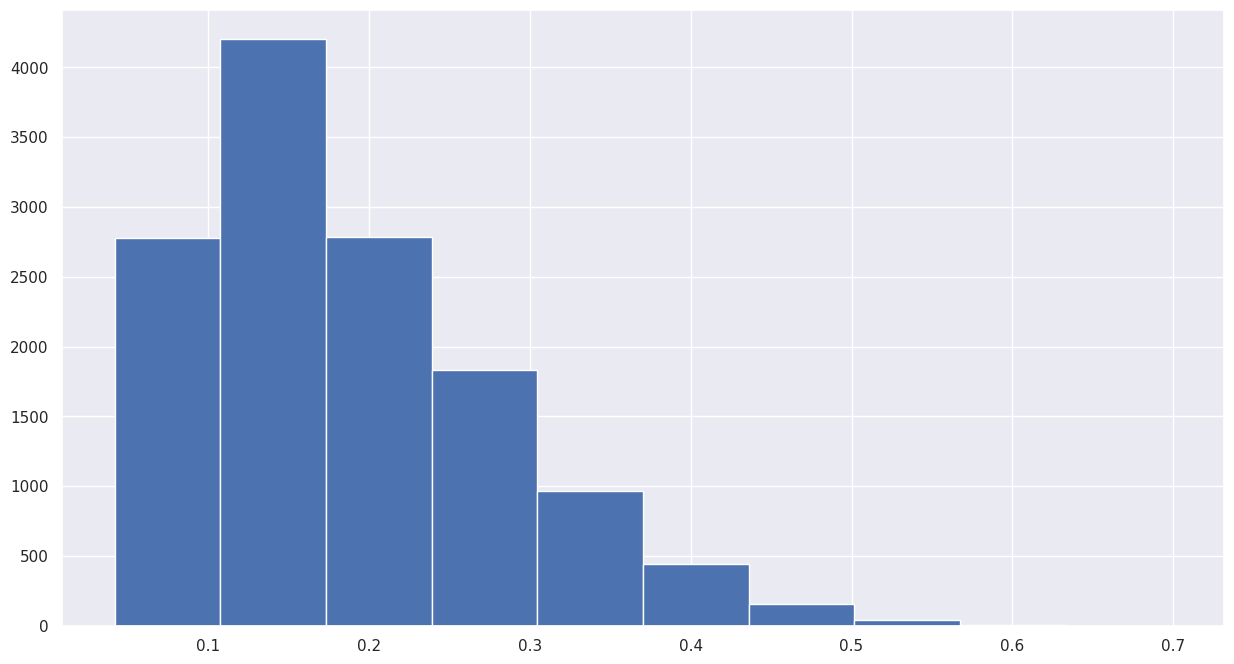

In [122]:
submit['score'].hist();

## Заключение: для выполнения столь сложной задачи с использованием графовых данных мы перебрали достаточно много теорий и выбрали самые подходящие. В итоге мы остановились на решении с 2 этапами:

### -1) Обучение основной модели с множеством идей и гипотез, а также выбором главной модели, выбором лучших колонок и выбором лучших гиперпараметров

### -2) Создание вторичной, подкрепляющей модели, которая помогает обобщить нашу вероятность, дополняя её предсказаниями для других подрядчиков

### Итоговый результат является совмещённым итогом 2 этапов